<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr2/blob/main/Romashenkov%20Leonid/LR_InspectrumClinic_RS_gr2_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт бибилиотек.

In [ ]:
import numpy as np # Работа с массивами данных
import pandas as pd # Работа с табличными данными

from tensorflow.keras.models import Sequential, Model # Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization # Основные слои
from tensorflow.keras.layers import Embedding, Flatten, Activation, Input, concatenate   # Слои и всякое
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional 		    # Слои
from tensorflow.keras.layers import  Conv1D, MaxPooling1D, GlobalMaxPooling1D 	    # Слои
from tensorflow.keras import utils # Функции-утилиты для работы с категориальными данными to_categoricall
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop # Оптимизаторы
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence # Токенизатор для преобразования текстов в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки
!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.utils import plot_model # Визуализация модели

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Матрица ошибок классификатора
from sklearn.utils import shuffle # Перемешивание данных
from sklearn.preprocessing import StandardScaler # Масштабирование данных
from sklearn.metrics import mean_squared_error, mean_absolute_error # Метрики для расчета ошибок
from sklearn.model_selection import train_test_split # Для разбивки на выборки

from google.colab import files # Для загрузки своей картинки
from google.colab import data_table # Красивые таблицы

from datetime import date # Для работы с датами

from IPython.display import clear_output

import io # Ввод/вывод текста, двоичных и необработанных потоков.
import gdown # Загрузка датасетов из облака google
import re # Регулярные выражения
import random# Случайные числа
import os # Команды ОС
import string
import math # Для округления

import matplotlib.pyplot as plt # Отрисовка графиков

%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 2.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Подключение Google диска и загрузка 1-го датасета

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!tar -xzvf /content/drive/MyDrive/УИИ/Base/dataset.xlsx.tgz
!ls -lh dataset.xlsx

dataset.xlsx
-rw-rw-r-- 1 1000 1000 31M May 16 11:36 dataset.xlsx


In [ ]:
df = pd.read_excel (r'dataset.xlsx')
df.shape

(1982, 4587)

In [ ]:
df.columns = [x.lower() for x in df.columns] # Приводим все заголовки к lowercase

# Первичная подготовка датасета

In [ ]:
df.dropna(axis=0, how='all', inplace=True) # axis=0 <-- строки (Удаляем все строки где только Nan)
df.dropna(axis=1, how='all', inplace=True) # axis=1 <-- столбцы (Удаляем все столбцы где только NaN)
df.shape

(1982, 3703)

In [ ]:
df.drop_duplicates(inplace=True) # Удаляем дубликаты строк во всех столбцах
df.shape

(1926, 3703)

In [ ]:
df.drop_duplicates(subset=['клиент'], keep=False, inplace=True) #  Удаляем дубликаты строк по колонке ['клиент']
# keep=False для полного удаления всех дубликатов, иначе оставляет первый. Мы удаляем всех, т.к. не знаем кто из них правильный
df['клиент'].nunique() # теперь только уникальные клиенты

1897

In [ ]:
# Удаляем строки где в колонке "заключениемк" стоит NaN
df = df.dropna(subset=['заключениемк'])
df = df.reset_index(drop=True) # Сбрасываем index. !!! Важно !!! Обя-но через присвоение, иначе в самом датасете ничего не меняется.
df.shape

(1492, 3703)

In [ ]:
# Делаем датафрейм df_stat где столбцы (index, column, non-null count, dtype)
# в строках соответственно номера, имена, кол-во не нулевых и тип данных
buffer = io.StringIO()
df.info(verbose=True, show_counts=True, buf=buffer)
lines = buffer.getvalue().splitlines()
df_stat = (pd.DataFrame([x.split() for x in lines[5:-2]], columns=lines[3].split())
       .drop('Count',axis=1)
       .rename(columns={'Non-Null':'NCount'}))
#df_stat = df_stat.set_index('#') # Если надо удалить нумерацию, но вроде нужна.
#print(df_stat)
df_stat = df_stat.astype({'NCount': np.int32}) # Приводим тип object к типу int32
df_stat

#                                             Column  NCount  \
0        0                      документпрохождениемедосмотра    1492   
1        1                                             клиент    1492   
2        2                                 клиентдатарождения    1492   
3        3                                          клиентпол    1492   
4        4                             клиентполпредставление    1492   
...    ...                                                ...     ...   
3698  3698            стоматология2_вп2_значениепредставление       1   
3699  3699                   терапия2_заключениефогк_значение       1   
3700  3700      терапия2_заключениефогк_значениепредставление       1   
3701  3701  офтальмология1_двигательныйаппаратглаздополнен...       1   
3702  3702  офтальмология1_двигательныйаппаратглаздополнен...       1   

               Dtype  
0             object  
1             object  
2     datetime64[ns]  
3             object  
4             object  
...              ...  
3698          object  
3699          object  
3700          object  
3701          object  
3702          object  

[3703 rows x 4 columns]

In [ ]:
# Хотим, чтобы все столбцы показывались
pd.set_option('display.max_columns', None) # http://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
data_table.enable_dataframe_formatter()
data_table.DataTable.max_columns=4587
data_table.DataTable.include_index=True
data_table.DataTable.max_rows=5

df.head(3)

документпрохождениемедосмотра                                клиент  \
0  7f41ca7e-7dac-11ec-80fc-0cc47aab8067  c91e3407-b81f-11e9-80cf-0cc47aab8067   
1  2ee1f9ac-83dd-11ec-80fc-0cc47aab8067  1a1a5fea-8b7f-11eb-80e8-0cc47aab8067   
2  9cbb191e-8e24-11ec-80fe-0cc47aab8067  7fe324e0-fa51-11eb-80f6-0cc47aab8067   

  клиентдатарождения клиентпол клиентполпредставление  \
0         1976-10-24   Женский                Женский   
1         1987-11-18   Мужской                Мужской   
2         1985-09-08   Мужской                Мужской   

  датазавершениямедосмотра  типмедосмотра типмедосмотрапредставление  \
0               2022-01-25  Периодический              Периодический   
1               2022-02-02  Периодический              Периодический   
2               2022-02-15  Периодический              Периодический   

   психосвидетельствование                            контрагент  цех  \
0                    False  23c173a7-30d9-11e7-80d8-708bcd7f83cd  NaN   
1                    False  a6d559b0-7835-11eb-80e8-0cc47aab8067  NaN   
2                    False  a6d559b0-7835-11eb-80e8-0cc47aab8067  NaN   

                                   профессия            заключениемк  \
0  Ведущий специалист по организации обуения                   Годен   
1                         Ведущий специалист                   Годен   
2                           Главный менеджер  ГоденСКоррекциейЗрения   

                           заключениемкпредставление  \
0                Годен к работе в указанных условиях   
1                Годен к работе в указанных условиях   
2  Годен к работе в указанных условиях (с коррекц...   

                                          заключение диспансернаягруппа  \
0                Годен к работе в указанных условиях                  I   
1                Годен к работе в указанных условиях               IIIа   
2  Годен к работе в указанных условиях (с коррекц...                 II   

  диспансернаягруппапредставление вредныефакторы  \
0                               I           11.4   
1                            IIIа          4.2.5   
2                              II          4.2.5   

  лабораторныеисследования1_документприем  \
0    9e79eef8-7dad-11ec-80fc-0cc47aab8067   
1    bb79abf1-83de-11ec-80fc-0cc47aab8067   
2    1dbc1e71-8e28-11ec-80fe-0cc47aab8067   

  лабораторныеисследования1_датаприема       лабораторныеисследования1_салон  \
0                  2022-01-25 12:08:42  1b071e3e-c87a-11e7-80de-708bcd7f83cd   
1                  2022-02-02 09:15:23  1b071e3e-c87a-11e7-80de-708bcd7f83cd   
2                  2022-02-15 11:25:51  1b071e3e-c87a-11e7-80de-708bcd7f83cd   

  лабораторныеисследования1_салонпредставление  \
0                                         МЦ№2   
1                                         МЦ№2   
2                                         МЦ№2   

  лабораторныеисследования1_специализация  \
0    e866ea50-093d-11e2-87b2-002618dcef2c   
1    e866ea50-093d-11e2-87b2-002618dcef2c   
2    e866ea50-093d-11e2-87b2-002618dcef2c   

  лабораторныеисследования1_специализацияпредставление  \
0                          Лабораторные исследования     
1                          Лабораторные исследования     
2                          Лабораторные исследования     

  лабораторныеисследования1_хр_рекомендация1  \
0                                        NaN   
1                                        NaN   
2                                        NaN   

  лабораторныеисследования1_хр_рекомендация1представление  \
0                                                NaN        
1                                                NaN        
2                                                NaN        

  лабораторныеисследования1_хр_рекомендация2  \
0                                        NaN   
1                                        NaN   
2                                        NaN   

  лабораторныеисследования1_оак_значение  \
0                                получен   
1             

In [ ]:
# Отбираем заголовки, которые будут использоваться в дальнейшем (Те, что сказал Антон)
# За исключением "мкб" т.к. они всегда в неполной мере дублируют соответствующее "заключениепредставление"
dfzag = df_stat[df_stat['Column'].str.fullmatch('клиент') | df_stat['Column'].str.fullmatch('клиентдатарождения') | df_stat['Column'].str.fullmatch('клиентпол') | df_stat['Column'].str.fullmatch('профессия') | df_stat['Column'].str.fullmatch('вредныефакторы') | df_stat['Column'].str.fullmatch('заключениемк') | df_stat['Column'].str.contains('диагноз_значениепредставление')]
dfzag.shape

(37, 4)

In [ ]:
dfzag_2 = dfzag[dfzag.NCount > 600] # Отбираем в заголовочный датафрейм только те записи в которых ненулевых значений > 600
dfzag_2

#                                             Column  NCount  \
1        1                                             клиент    1492   
2        2                                 клиентдатарождения    1492   
3        3                                          клиентпол    1492   
11      11                                          профессия    1492   
12      12                                       заключениемк    1492   
17      17                                     вредныефакторы    1492   
140    140  психиатриянаркология1_диагноз_значениепредстав...    1115   
200    200       офтальмология1_диагноз_значениепредставление     956   
259    259  оториноларингология1_диагноз_значениепредставл...    1163   
617    617  дерматовенерология1_диагноз_значениепредставление     701   
707    707          неврология1_диагноз_значениепредставление    1274   
847    847            хирургия1_диагноз_значениепредставление     753   
2844  2844             терапия1_диагноз_значениепредставление     850   

               Dtype  
1             object  
2     datetime64[ns]  
3             object  
11            object  
12            object  
17            object  
140           object  
200           object  
259           object  
617           object  
707           object  
847           object  
2844          object

In [ ]:
str = dfzag_2.Column.to_list() # Отобрал названия столбцов там, где не нулевых > 600
len(str)

13

In [ ]:
data = df[str]  # Создаю датафрейм (data) из исходного (df) со столбцами из моего списка.
data.head(3)

клиент клиентдатарождения клиентпол  \
0  c91e3407-b81f-11e9-80cf-0cc47aab8067         1976-10-24   Женский   
1  1a1a5fea-8b7f-11eb-80e8-0cc47aab8067         1987-11-18   Мужской   
2  7fe324e0-fa51-11eb-80f6-0cc47aab8067         1985-09-08   Мужской   

                                   профессия            заключениемк  \
0  Ведущий специалист по организации обуения                   Годен   
1                         Ведущий специалист                   Годен   
2                           Главный менеджер  ГоденСКоррекциейЗрения   

  вредныефакторы психиатриянаркология1_диагноз_значениепредставление  \
0           11.4          [Z00.0] Общий медицинский осмотр_x000D_\n    
1          4.2.5          [Z00.0] Общий медицинский осмотр_x000D_\n    
2          4.2.5          [Z00.0] Общий медицинский осмотр_x000D_\n    

        офтальмология1_диагноз_значениепредставление  \
0          [Z00.0] Общий медицинский осмотр_x000D_\n   
1          [Z00.0] Общий медицинский осмотр_x000D_\n   
2  [H52.1] Миопия_x000D_\nОписание: Миопия слабой...   

  оториноларингология1_диагноз_значениепредставление  \
0          [Z00.0] Общий медицинский осмотр_x000D_\n   
1                                                NaN   
2                                                NaN   

  дерматовенерология1_диагноз_значениепредставление  \
0                                               NaN   
1         [Z00.0] Общий медицинский осмотр_x000D_\n   
2         [Z00.0] Общий медицинский осмотр_x000D_\n   

   неврология1_диагноз_значениепредставление  \
0                                        NaN   
1  [Z00.0] Общий медицинский осмотр_x000D_\n   
2                                        NaN   

  хирургия1_диагноз_значениепредставление  \
0                                     NaN   
1                                     NaN   
2                                     NaN   

  терапия1_диагноз_значениепредставление  
0                                    NaN  
1                                    NaN  
2                                    NaN

In [ ]:
data['клиентдатарождения'].dtype

dtype('<M8[ns]')

In [ ]:
data['клиентдатарождения'] = data['клиентдатарождения'].dt.date
data['клиентдатарождения']

<ipython-input-294-6a6be52642ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['клиентдатарождения'] = data['клиентдатарождения'].dt.date


0       1976-10-24
1       1987-11-18
2       1985-09-08
3       1988-04-25
4       1984-04-17
           ...    
1487    1993-12-29
1488    1989-07-10
1489    1987-02-04
1490    1993-02-04
1491    1971-09-14
Name: клиентдатарождения, Length: 1492, dtype: object

In [ ]:
data['клиентдатарождения'] = pd.to_datetime(data['клиентдатарождения'], errors='coerce').dt.date # .dt.date даёт тип object  как
                                                                                                # и у date.today(), чтобы отнимать
                                                                                                # сравнимые данные когда будем
                                                                                                # вычислять возраст

<ipython-input-295-5eabb76fb329>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['клиентдатарождения'] = pd.to_datetime(data['клиентдатарождения'], errors='coerce').dt.date # .dt.date даёт тип object  как


In [ ]:
data['возраст'] = (date.today() - data['клиентдатарождения']).astype('<m8[Y]')  # Добавляет в конец датафрейма (data) столбец "возраст"
                                                                                # который вычисляется по формуле ("Дата сегодня" - "Дата рождения")
                                                                                # .astype(...) преобразует к понятным годам, иначе дни.

<ipython-input-296-b28d141506f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['возраст'] = (date.today() - data['клиентдатарождения']).astype('<m8[Y]')  # Добавляет в конец датафрейма (data) столбец "возраст"


In [ ]:
data['возраст']

0       46.0
1       35.0
2       37.0
3       35.0
4       39.0
        ... 
1487    29.0
1488    34.0
1489    36.0
1490    30.0
1491    51.0
Name: возраст, Length: 1492, dtype: float64

In [ ]:
data['возраст_класс'] = (data['возраст'] - 13)//7 # Приводим дату рождения к классам

<ipython-input-298-1c500de0356d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['возраст_класс'] = (data['возраст'] - 13)//7 # Приводим дату рождения к классам


In [ ]:
data['возраст_класс']

0       4.0
1       3.0
2       3.0
3       3.0
4       3.0
       ... 
1487    2.0
1488    3.0
1489    3.0
1490    2.0
1491    5.0
Name: возраст_класс, Length: 1492, dtype: float64

In [ ]:
# Вставляю в мой список заголовков новый заголовок "возраст_класс" по 2-му индексу. 0,1,2 <-- сюда
if str.count('возраст_класс') == 0: # Необходимо проверять, что уже добавил т.к. могу ещё раз запустить ячейку. Чтобы не добавлялось каждый раз.
    str.insert(3, 'возраст_класс')
else:
    print('Заголовок "возраст_класс" уже добавлен в список\n')

In [ ]:
# Удаляю ненужный более заголовок "клиентдатарождения" Можно было заодно сделать выше, но это неправильно.
# Лучше иметь атомарные операции, чем в одну пихать несколько.
if str.count('клиентдатарождения') > 0:
    str.remove('клиентдатарождения')
else:
    print('Заголовок "клиентдатарождения" уже удалён\n')

In [ ]:
str

['клиент',
 'клиентпол',
 'возраст_класс',
 'профессия',
 'заключениемк',
 'вредныефакторы',
 'психиатриянаркология1_диагноз_значениепредставление',
 'офтальмология1_диагноз_значениепредставление',
 'оториноларингология1_диагноз_значениепредставление',
 'дерматовенерология1_диагноз_значениепредставление',
 'неврология1_диагноз_значениепредставление',
 'хирургия1_диагноз_значениепредставление',
 'терапия1_диагноз_значениепредставление']

In [ ]:
data_new = data[str] # Получаем новый датафрейм с уже правильными заголовками

In [ ]:
data_new.dtypes # Смотрим какие типы данных у столбцов

клиент                                                  object
клиентпол                                               object
возраст_класс                                          float64
профессия                                               object
заключениемк                                            object
вредныефакторы                                          object
психиатриянаркология1_диагноз_значениепредставление     object
офтальмология1_диагноз_значениепредставление            object
оториноларингология1_диагноз_значениепредставление      object
дерматовенерология1_диагноз_значениепредставление       object
неврология1_диагноз_значениепредставление               object
хирургия1_диагноз_значениепредставление                 object
терапия1_диагноз_значениепредставление                  object
dtype: object

In [ ]:
# привели тип данных "возраст_класс" к int8 ВНИМАНИЕ!!! обязательно
data_new['возраст_класс'] = data_new['возраст_класс'].astype('int8') # присваиваем, иначе копию  возвращает

<ipython-input-305-ab817a5f3f15>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['возраст_класс'] = data_new['возраст_класс'].astype('int8') # присваиваем, иначе копию  возвращает


In [ ]:
data_new.dtypes

клиент                                                 object
клиентпол                                              object
возраст_класс                                            int8
профессия                                              object
заключениемк                                           object
вредныефакторы                                         object
психиатриянаркология1_диагноз_значениепредставление    object
офтальмология1_диагноз_значениепредставление           object
оториноларингология1_диагноз_значениепредставление     object
дерматовенерология1_диагноз_значениепредставление      object
неврология1_диагноз_значениепредставление              object
хирургия1_диагноз_значениепредставление                object
терапия1_диагноз_значениепредставление                 object
dtype: object

# Для очистки данных смотим уникальные значения в полученных столбцах

In [ ]:
# Удаляем клиента, чтобы вычислить все уникальные строки у всех остальных.
try: # Обязательно обрабатываем ошибку, чтобы много раз можно было запускать ячейку.
    str.remove('клиент')
except ValueError:
    print('Значение "клиент" уже удалено\n')

In [ ]:
def return_unique_col(df, lst):
    """
    Возвращает список уникальных значений столбца.
    Функции передаётся датасет и название столбца
    """
    r = df[lst].unique()
    return r

In [ ]:
return_unique_col(data_new, str[3])

array(['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах',
       'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден',
       'ОграниченноГоден', 'машинист бульдозера', 'Газоспасатель',
       ' Газоспасатель'], dtype=object)

In [ ]:
for x in str: # Печать уникальных значений всех столбцов.
    print('\n')
    print(f'Заголовок -> {x}\n')
    print(return_unique_col(data_new, x))



Заголовок -> клиентпол

['Женский' 'Мужской']


Заголовок -> возраст_класс

[4 3 2 5 1 6 7 0 8]


Заголовок -> профессия

['Ведущий специалист по организации обуения' 'Ведущий специалист'
 'Главный менеджер' 'Главный специалист' 'Старший специалист'
 'Начальник отдела' 'Старший инженер' 'Ведущий инженер ' 'Специалист '
 'Ведущий специалист ' 'Мойщик ВС 2 разряда' 'Кладовщик-комплектовщик'
 'Кладовщик комплектовщик' 'Мойщик службы БОВС' 'Старший кладовщик'
 'Комплектовщик' 'Уборщик производственных помещений'
 'Агент-комплектовщик' 'Уборщик производственных помещений '
 'ведущий инженер' 'Руководитель сектора ' 'Ведущий инженер'
 'Старшй инженер' 'Старший специалист ' 'Специалист' 'Официант'
 'Ведущий геодезист' 'Техник' 'Старший техник' 'Главный специалист '
 'управление наземными транспортными средствами (кат В)'
 'Слесарь-сантехник' 'Слесарь по ремонту автомобилей 6 разряда'
 'Слесарь по ремонту автомобилей' 'Мерчендайзер '
 'Геофизик полевого вычислительного центра 1 категории'
 '

# Первые итоги анализа данных:
Выводы по полученным уникальным значениям в столбцах:

    'клиент',
    'возраст_класс',
    'клиентпол',
    'профессия',<=== тут привести всё к нижнему регистру
    'заключениемк',<=== тут удалить левые + нан???
    'вредныефакторы',<=== тут удалить сроку с нецифровыми знаками
    'психиатриянаркология1_мкб101',<=== тоже удалить строку с нецифровыми знаками
    'психиатриянаркология1_диагноз_значениепредставление',<=== тут удалить _x000D_\n + 'be95d37b-8a23-11ec-80fc-0cc47aab8067'
    'офтальмология1_диагноз_значениепредставление',<=== тоже удалить _x000D_\n
    'оториноларингология1_диагноз_значениепредставление',<=== тут удалить _x000D_\n + 'общий медицинский осмотр '
    'стоматология1_диагноз_значениепредставление',<=== тут удалить _x000D_\n + '1a934758-34a9-11e8-80c9-0cc47aab8067'
    'дерматовенерология1_мкб101',
    'дерматовенерология1_диагноз_значениепредставление',<=== тут удалить _x000D_\n + '31cebbd0-244c-11e8-80c9-0cc47aab8067'
    'неврология1_диагноз_значениепредставление',<=== тут удалить _x000D_\n
    'хирургия1_диагноз_значениепредставление',<=== тоже удалить _x000D_\n Там только [nan 'Z00.0']
    'терапия1_диагноз_значениепредставление'<=== тоже удалить _x000D_\n

Дополнительно:

    удалять ==> '_x000D_\n_x000D_\n1. '
    '_x00D_\n' ==> заменять пробелом ' '
    так же в 18. пункте 'нет' удалилась вместе с первым удалением

In [ ]:
# Пока не придумал ничего лучше. Тупо удаляю вручную. Потом придумать!!!!
for x in str:
    if x == 'профессия':
        data_new[x] = data_new[x].str.lower()
    if x == 'заключениемк':
        data_new.drop(data_new[data_new['заключениемк'] == 'Газоспасатель'].index, inplace = True)
        data_new.drop(data_new[data_new['заключениемк'] == ' Газоспасатель'].index, inplace = True)
        data_new.drop(data_new[data_new['заключениемк'] == 'машинист бульдозера'].index, inplace = True)
        data_new.drop(data_new[data_new['заключениемк'] == 'nan'].index, inplace = True)
    if x == 'вредныефакторы':
        data_new.drop(data_new[data_new['вредныефакторы'] == 'Годен к работе в указанных условиях'].index, inplace=True)
    if x == 'психиатриянаркология1_диагноз_значениепредставление':
        data_new.drop(data_new[data_new['психиатриянаркология1_диагноз_значениепредставление'] == 'be95d37b-8a23-11ec-80fc-0cc47aab8067'].index, inplace=True)
    if x == 'оториноларингология1_диагноз_значениепредставление':
        data_new.drop(data_new[data_new['оториноларингология1_диагноз_значениепредставление'] == 'общий медицинский осмотр '].index, inplace=True)
    if x == 'стоматология1_диагноз_значениепредставление':
        data_new.drop(data_new[data_new['терапия1_диагноз_значениепредставление'] == '1a934758-34a9-11e8-80c9-0cc47aab8067'].index, inplace=True)
    if x == 'дерматовенерология1_диагноз_значениепредставление':
        data_new.drop(data_new[data_new['дерматовенерология1_диагноз_значениепредставление'] == '31cebbd0-244c-11e8-80c9-0cc47aab8067'].index, inplace=True)


<ipython-input-311-8086fe71ccee>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new[x] = data_new[x].str.lower()
<ipython-input-311-8086fe71ccee>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new.drop(data_new[data_new['заключениемк'] == 'Газоспасатель'].index, inplace = True)
<ipython-input-311-8086fe71ccee>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ne

In [ ]:
# Профессию к нижнему регистру
data_new['профессия'] = data_new['профессия'].str.lower()

<ipython-input-312-44210336da48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['профессия'] = data_new['профессия'].str.lower()


In [ ]:
# Удаляем '_x000D_\n_x000D_\n1. ' В начале строк.
data_new = data_new.replace('^_x000D_\n_x000D_\n1. ', '', regex=True)

In [ ]:
# Заменяем фигню пробелом
data_new = data_new.replace('_x000D_\n', ' ', regex = True)

In [ ]:
# Приводим гендер к значениям "Мужской" = 1, "Женский" = 0
data_new.loc[data_new['клиентпол'] == 'Мужской', 'клиентпол'] = '1'
data_new.loc[data_new['клиентпол'] == 'Женский', 'клиентпол'] = '0'

In [ ]:
# Приводим 'заключениемк' к виду 'Годен' = 1, 'Все остальное' = 0
# Учимся векторизовать вместо .loc и iterrows()
# Функция where принимает первым аргументом условие, вторым — результат выполнения условия, третьим — результат невыполнения условия.
# numpy - это числовые значения. Не строки!!!
##data_new['заключениемк'] = np.where(
##    data_new['заключениемк'] == 'Годен',
##    1,
##    0
##)

In [ ]:
data_new['заключениемк']

0                        Годен
1                        Годен
2       ГоденСКоррекциейЗрения
3                        Годен
4       ГоденСКоррекциейЗрения
                 ...          
1487                     Годен
1488                     Годен
1489                     Годен
1490                     Годен
1491                     Годен
Name: заключениемк, Length: 1486, dtype: object

In [ ]:
#data_new['заключениемк'] = data_new['заключениемк'].reshape(-1, 1)

In [ ]:
data_new

клиент клиентпол  возраст_класс  \
0     c91e3407-b81f-11e9-80cf-0cc47aab8067         0              4   
1     1a1a5fea-8b7f-11eb-80e8-0cc47aab8067         1              3   
2     7fe324e0-fa51-11eb-80f6-0cc47aab8067         1              3   
3     98f9d761-8d65-11ec-80fe-0cc47aab8067         1              3   
4     009aac7d-7bcf-11eb-80e8-0cc47aab8067         1              3   
...                                    ...       ...            ...   
1487  d334f0e5-2ff4-11ec-80f9-0cc47aab8067         1              2   
1488  e00ba1a0-2ff4-11ec-80f9-0cc47aab8067         1              3   
1489  90fa4fca-2495-11e9-80ce-0cc47aab8067         1              3   
1490  febbe86c-5f5b-11ea-80dc-0cc47aab8067         1              2   
1491  920293ea-32c2-11eb-80e3-0cc47aab8067         1              5   

                                              профессия  \
0             ведущий специалист по организации обуения   
1                                    ведущий специалист   
2                                      главный менеджер   
3                                    главный специалист   
4                                    старший специалист   
...                                                 ...   
1487                                            инженер   
1488                              начальник лаборатории   
1489  инженер по бурению 1 категории, непосредственн...   
1490                           приемщик вагонов в депо    
1491                                       анестезиолог   

                заключениемк вредныефакторы  \
0                      Годен           11.4   
1                      Годен          4.2.5   
2     ГоденСКоррекциейЗрения          4.2.5   
3                      Годен           11.1   
4     ГоденСКоррекциейЗрения           11.1   
...                      ...            ...   
1487                   Годен    4.4,4.5,6.1   
1488                   Годен            4.4   
1489                   Годен        3.1.8.2   
1490                   Годен      4.2.5,6.1   
1491                   Годен             27   

     психиатриянаркология1_диагноз_значениепредставление  \
0                     [Z00.0] Общий медицинский осмотр     
1                     [Z00.0] Общий медицинский осмотр     
2                     [Z00.0] Общий медицинский осмотр     
3                                                   NaN    
4                                                   NaN    
...                                                 ...    
1487                  [Z00.0] Общий медицинский осмотр     
1488                  [Z00.0] Общий медицинский осмотр     
1489                  [Z00.0] Общий медицинский осмотр     
1490                  [Z00.0] Общий медицинский осмотр     
1491                  [Z00.0] Общий медицинский осмотр     

           офтальмология1_диагноз_значениепредставление  \
0                     [Z00.0] Общий медицинский осмотр    
1                     [Z00.0] Общий медицинский осмотр    
2     [H52.1] Миопия Описание: Миопия слабой степени...   
3                     [Z00.0] Общий медицинский осмотр    
4     [H52.2] Астигматизм Описание: Миопический асти...   
...                                                 ...   
1487                  [Z00.0] Общий медицинский осмотр    
1488                                                NaN   
1489                  [Z00.0] Общий медицинский осмотр    
1490                  [Z00.0] Общий медицинский осмотр    
1491                                                NaN   

     оториноларингология1_диагноз_значениепредставление  \
0                     [Z00.0] Общий медицинский осмотр    
1                                                   NaN   
2                                                   NaN   
3                     [Z00.0] Общий медицинский осмотр    
4                     [Z00.0] Общий медицинский осмотр    
...                                                 ...   
1487                  [Z00.0] Общий медицинский осмотр    
1488   

In [ ]:
# Почему-то индекс не соответствует, поэтому пересоздам.
data_new = data_new.reset_index(drop=True)

In [ ]:
data_new

клиент клиентпол  возраст_класс  \
0     c91e3407-b81f-11e9-80cf-0cc47aab8067         0              4   
1     1a1a5fea-8b7f-11eb-80e8-0cc47aab8067         1              3   
2     7fe324e0-fa51-11eb-80f6-0cc47aab8067         1              3   
3     98f9d761-8d65-11ec-80fe-0cc47aab8067         1              3   
4     009aac7d-7bcf-11eb-80e8-0cc47aab8067         1              3   
...                                    ...       ...            ...   
1481  d334f0e5-2ff4-11ec-80f9-0cc47aab8067         1              2   
1482  e00ba1a0-2ff4-11ec-80f9-0cc47aab8067         1              3   
1483  90fa4fca-2495-11e9-80ce-0cc47aab8067         1              3   
1484  febbe86c-5f5b-11ea-80dc-0cc47aab8067         1              2   
1485  920293ea-32c2-11eb-80e3-0cc47aab8067         1              5   

                                              профессия  \
0             ведущий специалист по организации обуения   
1                                    ведущий специалист   
2                                      главный менеджер   
3                                    главный специалист   
4                                    старший специалист   
...                                                 ...   
1481                                            инженер   
1482                              начальник лаборатории   
1483  инженер по бурению 1 категории, непосредственн...   
1484                           приемщик вагонов в депо    
1485                                       анестезиолог   

                заключениемк вредныефакторы  \
0                      Годен           11.4   
1                      Годен          4.2.5   
2     ГоденСКоррекциейЗрения          4.2.5   
3                      Годен           11.1   
4     ГоденСКоррекциейЗрения           11.1   
...                      ...            ...   
1481                   Годен    4.4,4.5,6.1   
1482                   Годен            4.4   
1483                   Годен        3.1.8.2   
1484                   Годен      4.2.5,6.1   
1485                   Годен             27   

     психиатриянаркология1_диагноз_значениепредставление  \
0                     [Z00.0] Общий медицинский осмотр     
1                     [Z00.0] Общий медицинский осмотр     
2                     [Z00.0] Общий медицинский осмотр     
3                                                   NaN    
4                                                   NaN    
...                                                 ...    
1481                  [Z00.0] Общий медицинский осмотр     
1482                  [Z00.0] Общий медицинский осмотр     
1483                  [Z00.0] Общий медицинский осмотр     
1484                  [Z00.0] Общий медицинский осмотр     
1485                  [Z00.0] Общий медицинский осмотр     

           офтальмология1_диагноз_значениепредставление  \
0                     [Z00.0] Общий медицинский осмотр    
1                     [Z00.0] Общий медицинский осмотр    
2     [H52.1] Миопия Описание: Миопия слабой степени...   
3                     [Z00.0] Общий медицинский осмотр    
4     [H52.2] Астигматизм Описание: Миопический асти...   
...                                                 ...   
1481                  [Z00.0] Общий медицинский осмотр    
1482                                                NaN   
1483                  [Z00.0] Общий медицинский осмотр    
1484                  [Z00.0] Общий медицинский осмотр    
1485                                                NaN   

     оториноларингология1_диагноз_значениепредставление  \
0                     [Z00.0] Общий медицинский осмотр    
1                                                   NaN   
2                                                   NaN   
3                     [Z00.0] Общий медицинский осмотр    
4                     [Z00.0] Общий медицинский осмотр    
...                                                 ...   
1481                  [Z00.0] Общий медицинский осмотр    
1482   

In [ ]:
# Заменяем nan во всём оставшемся датасете на '', так как по большому счёту это не влияет ни на что.
data_new = data_new.fillna('')

In [ ]:
for x in data_new.columns: # Печать уникальных значений всех столбцов
    print('\n')
    print(f'Заголовок -> {x}\n')
    print(return_unique_col(data_new, x))



Заголовок -> клиент

['c91e3407-b81f-11e9-80cf-0cc47aab8067'
 '1a1a5fea-8b7f-11eb-80e8-0cc47aab8067'
 '7fe324e0-fa51-11eb-80f6-0cc47aab8067' ...
 '90fa4fca-2495-11e9-80ce-0cc47aab8067'
 'febbe86c-5f5b-11ea-80dc-0cc47aab8067'
 '920293ea-32c2-11eb-80e3-0cc47aab8067']


Заголовок -> клиентпол

['0' '1']


Заголовок -> возраст_класс

[4 3 2 5 1 6 7 0 8]


Заголовок -> профессия

['ведущий специалист по организации обуения' 'ведущий специалист'
 'главный менеджер' 'главный специалист' 'старший специалист'
 'начальник отдела' 'старший инженер' 'ведущий инженер ' 'специалист '
 'ведущий специалист ' 'мойщик вс 2 разряда' 'кладовщик-комплектовщик'
 'кладовщик комплектовщик' 'мойщик службы бовс' 'старший кладовщик'
 'комплектовщик' 'уборщик производственных помещений'
 'агент-комплектовщик' 'уборщик производственных помещений '
 'ведущий инженер' 'руководитель сектора ' 'старшй инженер'
 'старший специалист ' 'специалист' 'официант' 'ведущий геодезист'
 'техник' 'старший техник' 'главный спец

In [ ]:
#  Удаляем всё в квадратных скобках. Дублируют текст. Не нужны.
data_new = data_new.replace('\[[A-Z][0-9]{2}[.][0-9]\]', '', regex = True)

In [ ]:
# Удаляем [J00] откуда-то затесалось
data_new = data_new.replace('\[J00\]', '', regex = True)

In [ ]:
# Удаляем не нужные ' \[' '\] '
data_new = data_new.replace(' \[', '', regex = True)
data_new = data_new.replace('\] ', '', regex = True)

In [ ]:
#  Удаляем 'Общий медицинский осмотр '
data_new = data_new.replace(' Общий медицинский осмотр ', '')

In [ ]:
for x in data_new.columns: # Печать уникальных значений всех столбцов.
    print('\n')
    print(f'Заголовок -> {x}\n')
    print(return_unique_col(data_new, x))



Заголовок -> клиент

['c91e3407-b81f-11e9-80cf-0cc47aab8067'
 '1a1a5fea-8b7f-11eb-80e8-0cc47aab8067'
 '7fe324e0-fa51-11eb-80f6-0cc47aab8067' ...
 '90fa4fca-2495-11e9-80ce-0cc47aab8067'
 'febbe86c-5f5b-11ea-80dc-0cc47aab8067'
 '920293ea-32c2-11eb-80e3-0cc47aab8067']


Заголовок -> клиентпол

['0' '1']


Заголовок -> возраст_класс

[4 3 2 5 1 6 7 0 8]


Заголовок -> профессия

['ведущий специалист по организации обуения' 'ведущий специалист'
 'главный менеджер' 'главный специалист' 'старший специалист'
 'начальник отдела' 'старший инженер' 'ведущий инженер ' 'специалист '
 'ведущий специалист ' 'мойщик вс 2 разряда' 'кладовщик-комплектовщик'
 'кладовщик комплектовщик' 'мойщик службы бовс' 'старший кладовщик'
 'комплектовщик' 'уборщик производственных помещений'
 'агент-комплектовщик' 'уборщик производственных помещений '
 'ведущий инженер' 'руководитель сектора ' 'старшй инженер'
 'старший специалист ' 'специалист' 'официант' 'ведущий геодезист'
 'техник' 'старший техник' 'главный спец

# Данные почти чистые.
Возможно понадобится доп.очистка.

In [ ]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486 entries, 0 to 1485
Data columns (total 13 columns):
 #   Column                                               Non-Null Count  Dtype 
---  ------                                               --------------  ----- 
 0   клиент                                               1486 non-null   object
 1   клиентпол                                            1486 non-null   object
 2   возраст_класс                                        1486 non-null   int8  
 3   профессия                                            1486 non-null   object
 4   заключениемк                                         1486 non-null   object
 5   вредныефакторы                                       1486 non-null   object
 6   психиатриянаркология1_диагноз_значениепредставление  1486 non-null   object
 7   офтальмология1_диагноз_значениепредставление         1486 non-null   object
 8   оториноларингология1_диагноз_значениепредставление   1486 non-null   object
 9

In [ ]:
column_list = data_new.columns.to_list()
print(column_list)

['клиент', 'клиентпол', 'возраст_класс', 'профессия', 'заключениемк', 'вредныефакторы', 'психиатриянаркология1_диагноз_значениепредставление', 'офтальмология1_диагноз_значениепредставление', 'оториноларингология1_диагноз_значениепредставление', 'дерматовенерология1_диагноз_значениепредставление', 'неврология1_диагноз_значениепредставление', 'хирургия1_диагноз_значениепредставление', 'терапия1_диагноз_значениепредставление']


In [ ]:
n = 1234 # Берем любого клиента
column_list = data_new.columns.tolist() #список столбцов
for i in range(len(data_new.values[n])): # Выводим значение каждого столбца для выбранного клиента
  print(i, " ", column_list[i],":",data_new.values[n][i])

0   клиент : 65b30f28-a225-11e8-80ce-0cc47aab8067
1   клиентпол : 1
2   возраст_класс : 3
3   профессия : наладчик станков и манипуляторов с программным управлением 4 разряд
4   заключениемк : ГоденСКоррекциейЗрения
5   вредныефакторы : 15
6   психиатриянаркология1_диагноз_значениепредставление :  Тремор неуточненный 
7   офтальмология1_диагноз_значениепредставление :  Астигматизм Описание: Миопический астигматизм ОИ 
8   оториноларингология1_диагноз_значениепредставление : 
9   дерматовенерология1_диагноз_значениепредставление : 
10   неврология1_диагноз_значениепредставление : 
11   хирургия1_диагноз_значениепредставление : 
12   терапия1_диагноз_значениепредставление : 


In [ ]:
# Объединяем всех узких спец-ов
data_new['all'] = data_new[['психиатриянаркология1_диагноз_значениепредставление',
                            'офтальмология1_диагноз_значениепредставление',
                            'оториноларингология1_диагноз_значениепредставление',
                            'дерматовенерология1_диагноз_значениепредставление',
                            'неврология1_диагноз_значениепредставление',
                            'хирургия1_диагноз_значениепредставление',
                            'терапия1_диагноз_значениепредставление']].agg(lambda x: ','.join(x.values), axis=1).T

In [ ]:
# Удаляем всех узких спецов
data_new = data_new.drop(columns = ['психиатриянаркология1_диагноз_значениепредставление',
                                    'офтальмология1_диагноз_значениепредставление',
                                    'оториноларингология1_диагноз_значениепредставление',
                                    'дерматовенерология1_диагноз_значениепредставление',
                                    'неврология1_диагноз_значениепредставление',
                                    'хирургия1_диагноз_значениепредставление',
                                    'терапия1_диагноз_значениепредставление'])

In [ ]:
n = 234 # Берем любого клиента
column_list = data_new.columns.tolist() #список столбцов
for i in range(len(data_new.values[n])): # Выводим значение каждого столбца для выбранного клиента
  print(i, " ", column_list[i],":",data_new.values[n][i])

0   клиент : 225b168f-ca2e-11e9-80cf-0cc47aab8067
1   клиентпол : 1
2   возраст_класс : 3
3   профессия : механик
4   заключениемк : ГоденСКоррекциейЗрения
5   вредныефакторы : 4.2.5,11.1,11.4
6   all : , Астигматизм Описание: Сложный Миопический астигматизм ОД Миопия сл ст ОС ,,,,,


In [ ]:
for x in data_new.columns: # Печать уникальных значений всех столбцов
    print('\n')
    print(f'Заголовок -> {x}\n')
    print(return_unique_col(data_new, x))



Заголовок -> клиент

['c91e3407-b81f-11e9-80cf-0cc47aab8067'
 '1a1a5fea-8b7f-11eb-80e8-0cc47aab8067'
 '7fe324e0-fa51-11eb-80f6-0cc47aab8067' ...
 '90fa4fca-2495-11e9-80ce-0cc47aab8067'
 'febbe86c-5f5b-11ea-80dc-0cc47aab8067'
 '920293ea-32c2-11eb-80e3-0cc47aab8067']


Заголовок -> клиентпол

['0' '1']


Заголовок -> возраст_класс

[4 3 2 5 1 6 7 0 8]


Заголовок -> профессия

['ведущий специалист по организации обуения' 'ведущий специалист'
 'главный менеджер' 'главный специалист' 'старший специалист'
 'начальник отдела' 'старший инженер' 'ведущий инженер ' 'специалист '
 'ведущий специалист ' 'мойщик вс 2 разряда' 'кладовщик-комплектовщик'
 'кладовщик комплектовщик' 'мойщик службы бовс' 'старший кладовщик'
 'комплектовщик' 'уборщик производственных помещений'
 'агент-комплектовщик' 'уборщик производственных помещений '
 'ведущий инженер' 'руководитель сектора ' 'старшй инженер'
 'старший специалист ' 'специалист' 'официант' 'ведущий геодезист'
 'техник' 'старший техник' 'главный спец

In [ ]:
# Собираем уникальные значения data_new.вредныефакторы.values для будущего токенайзера
harm_text = data_new.вредныефакторы.values
#print(*harm_text, sep='\n')
ht = []
for i in harm_text:
    s = i.split(',')
    ht = ht + s

res = np.array(ht)
ht = np.unique(res)
len(ht)

91

In [ ]:
ht

array(['1.1', '1.14.1', '1.14.2', '1.15', '1.17', '1.18.3', '1.19.1',
       '1.2', '1.23', '1.24', '1.29', '1.29.1', '1.29.2', '1.29.4', '1.3',
       '1.30.1', '1.34.1', '1.36', '1.36.1', '1.37', '1.37.1', '1.37.1.1',
       '1.37.1.2', '1.39', '1.45.1', '1.46', '1.48', '1.49', '1.49.14',
       '1.49.2', '1.50', '1.8.1', '1.8.1.1', '1.8.1.2', '1.8.2',
       '1.8.2.1', '1.8.2.2', '1.8.3', '1.8.3.1', '1.8.3.2', '10', '11',
       '11.1', '11.2', '11.3', '11.4', '12', '13', '14', '15', '17', '18',
       '18.1', '18.2', '2.4', '2.4.3', '22', '23', '24', '25', '26', '27',
       '3.1', '3.1.2', '3.1.7', '3.1.8.1', '3.1.8.2', '3.1.8.3', '3.4',
       '4.1', '4.10', '4.2', '4.2.1', '4.2.3', '4.2.4', '4.2.5', '4.3.1',
       '4.3.2', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5.1', '5.2',
       '6', '6.1', '6.2', '8', '9'], dtype='<U8')

In [ ]:
dict_клиент = dict(zip(data_new.index, data_new['клиент']))
dict_возраст_класс = dict(zip(data_new.index, data_new['возраст_класс']))
dict_клиентпол = dict(zip(data_new.index, data_new['клиентпол']))
dict_профессия = dict(zip(data_new.index, data_new['профессия']))
dict_заключениемк = dict(zip(data_new.index, data_new['заключениемк']))
dict_вредныефакторы = dict(zip(data_new.index, data_new['вредныефакторы']))
dict_all = dict(zip(data_new.index, data_new['all']))

# Токенизация
    возраст_класс = OHE [0,0,1,0,0,0,0,0,0]
    клиентпол = OHE [0/1]
    профессия = BoW
    заключениемк = OHE [0/1]
    вредныефакторы = BoW
    all = BoW


In [ ]:
idx = data_new.shape[0]
print(idx)

1486


In [ ]:
age = [0, 0, 0, 0, 0, 0, 0, 0, 0]
for i in range(data_new.shape[0]):
    if dict_возраст_класс[i] == 0:
        age = [1,0,0,0,0,0,0,0,0]
    elif dict_возраст_класс[i] == 1:
        age = [0,1,0,0,0,0,0,0,0]
    elif dict_возраст_класс[i] == 2:
        age = [0,0,1,0,0,0,0,0,0]
    elif dict_возраст_класс[i] == 3:
        age = [0,0,0,1,0,0,0,0,0]
    elif dict_возраст_класс[i] == 4:
        age = [0,0,0,0,1,0,0,0,0]
    elif dict_возраст_класс[i] == 5:
        age = [0,0,0,0,0,1,0,0,0]
    elif dict_возраст_класс[i] == 6:
        age = [0,0,0,0,0,0,1,0,0]
    elif dict_возраст_класс[i] == 7:
        age = [0,0,0,0,0,0,0,1,0]
    elif dict_возраст_класс[i] == 8:
        age = [0,0,0,0,0,0,0,0,1]
    print(f'index = {i} sex = {dict_клиентпол[i]} age = {age} conclusion = {dict_заключениемк[i]}')

index = 0 sex = 0 age = [0, 0, 0, 0, 1, 0, 0, 0, 0] conclusion = Годен
index = 1 sex = 1 age = [0, 0, 0, 1, 0, 0, 0, 0, 0] conclusion = Годен
index = 2 sex = 1 age = [0, 0, 0, 1, 0, 0, 0, 0, 0] conclusion = ГоденСКоррекциейЗрения
index = 3 sex = 1 age = [0, 0, 0, 1, 0, 0, 0, 0, 0] conclusion = Годен
index = 4 sex = 1 age = [0, 0, 0, 1, 0, 0, 0, 0, 0] conclusion = ГоденСКоррекциейЗрения
index = 5 sex = 1 age = [0, 0, 1, 0, 0, 0, 0, 0, 0] conclusion = Годен
index = 6 sex = 1 age = [0, 0, 0, 1, 0, 0, 0, 0, 0] conclusion = ГоденСКоррекциейЗрения
index = 7 sex = 1 age = [0, 0, 1, 0, 0, 0, 0, 0, 0] conclusion = Годен
index = 8 sex = 1 age = [0, 0, 0, 0, 1, 0, 0, 0, 0] conclusion = Годен
index = 9 sex = 1 age = [0, 0, 0, 1, 0, 0, 0, 0, 0] conclusion = Годен
index = 10 sex = 1 age = [0, 0, 1, 0, 0, 0, 0, 0, 0] conclusion = ГоденСКоррекциейЗрения
index = 11 sex = 1 age = [0, 0, 0, 0, 0, 1, 0, 0, 0] conclusion = Годен
index = 12 sex = 1 age = [0, 0, 0, 1, 0, 0, 0, 0, 0] conclusion = Годен
index 


    0 клиент : 225b168f-ca2e-11e9-80cf-0cc47aab8067
    1 клиентпол : 1
    2 возраст_класс : 3
    3 профессия : механик
    4 заключениемк : 0
    5 вредныефакторы : 4.2.5,11.1,11.4
    6 all : , Астигматизм Описание: Сложный Миопический астигматизм ОД Миопия сл ст ОС ,,,,,

In [ ]:
data_new.values[0][2]

4

In [ ]:
data_new.head(3)

клиент клиентпол  возраст_класс  \
0  c91e3407-b81f-11e9-80cf-0cc47aab8067         0              4   
1  1a1a5fea-8b7f-11eb-80e8-0cc47aab8067         1              3   
2  7fe324e0-fa51-11eb-80f6-0cc47aab8067         1              3   

                                   профессия            заключениемк  \
0  ведущий специалист по организации обуения                   Годен   
1                         ведущий специалист                   Годен   
2                           главный менеджер  ГоденСКоррекциейЗрения   

  вредныефакторы                                                all  
0           11.4                                             ,,,,,,  
1          4.2.5                                             ,,,,,,  
2          4.2.5  , Миопия Описание: Миопия слабой степени обоих...

# Простые данные + нейронка

In [ ]:
# Полученный возраст превращаем в класс возрастной категории
def getParameterAgeVect(arg):
  outClass =int(arg)
  outClass = max(0, min(10,outClass))
  # На выходе получаем вектор с нужной категорией возраста
  return list(utils.to_categorical(outClass, 9).astype('int'))

In [ ]:
age = getParameterAgeVect(data_new.values[0][2])
print(age)

[0, 0, 0, 0, 1, 0, 0, 0, 0]


In [ ]:
# Создаём заключение
def getParameterZakl(arg):
    out = [0]
    if "Годен" in arg:
        out[0] = 1
    else:
        out[0] = 0
    return out

In [ ]:
zakl = getParameterZakl(data_new.values[0][1])
print(zakl)

[0]


In [ ]:
# Извлекаем все параметры
def getAllParameters(val):
  sex = val[1] #гендер
  age = getParameterAgeVect(val[2]) #вектор возраста
  out = []

# Склеиваем все параметры в вектор
  out.append(sex)
  out += age

  return out

In [ ]:
# Создаем тренировочную выборку
def get01Data(values):
  xTrain = []
  yTrain = []

  # Предсказываем диагноз
  for val in values:
    y = getParameterZakl(val[4])
    x = getAllParameters(val)
    xTrain.append(x)
    yTrain.append(y)

  xTrain = np.array(xTrain)
  yTrain = np.array(yTrain)

  return (xTrain, yTrain)

In [ ]:
(xTrain01, yTrain) = get01Data(data_new.values) # Извлекаем значения загруженного набора данных

In [ ]:
# Размер набора параметров и диагнозов
print(xTrain01.shape)
print(yTrain.shape)
# Пример обработанных данных
n = 234
print(xTrain01[n])
print(yTrain[n])

(1486, 10)
(1486, 1)
['1' '0' '0' '0' '1' '0' '0' '0' '0' '0']
[1]


In [ ]:
xTrain01.shape[1]

10

In [ ]:
xTrain01.dtype

dtype('<U21')

In [ ]:
xTrain01 = xTrain01.astype(int)

In [ ]:
xTrain01.dtype

dtype('int64')

Epoch 1/50
40/40 - 2s - loss: 0.0134 - accuracy: 0.9889 - val_loss: 0.0134 - val_accuracy: 0.9865 - 2s/epoch - 51ms/step
Epoch 2/50
40/40 - 0s - loss: 0.0040 - accuracy: 0.9960 - val_loss: 0.0134 - val_accuracy: 0.9865 - 182ms/epoch - 5ms/step
Epoch 3/50
40/40 - 0s - loss: 0.0040 - accuracy: 0.9960 - val_loss: 0.0134 - val_accuracy: 0.9865 - 185ms/epoch - 5ms/step
Epoch 4/50
40/40 - 0s - loss: 0.0040 - accuracy: 0.9960 - val_loss: 0.0134 - val_accuracy: 0.9865 - 170ms/epoch - 4ms/step
Epoch 5/50
40/40 - 0s - loss: 0.0040 - accuracy: 0.9960 - val_loss: 0.0134 - val_accuracy: 0.9865 - 185ms/epoch - 5ms/step
Epoch 6/50
40/40 - 0s - loss: 0.0040 - accuracy: 0.9960 - val_loss: 0.0135 - val_accuracy: 0.9865 - 177ms/epoch - 4ms/step
Epoch 7/50
40/40 - 0s - loss: 0.0040 - accuracy: 0.9960 - val_loss: 0.0135 - val_accuracy: 0.9865 - 166ms/epoch - 4ms/step
Epoch 8/50
40/40 - 0s - loss: 0.0040 - accuracy: 0.9960 - val_loss: 0.0135 - val_accuracy: 0.9865 - 163ms/epoch - 4ms/step
Epoch 9/50
40/40 -

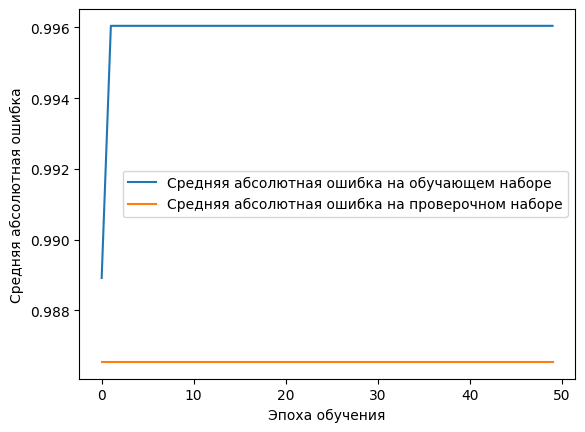

In [ ]:
# Обучаем модель полученными данными
model = Sequential()
model.add(BatchNormalization(input_shape=(xTrain01.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1000, activation='tanh'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=1e-5), loss='mse', metrics=['accuracy'])

history = model.fit(xTrain01,
                    yTrain,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.15,
                    verbose=2)

plt.plot(history.history['accuracy'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
# Делаем предсказание и приводим его к начальному виду
pred = model.predict(xTrain01)
pred = pred.flatten()
# Среднее значение ошибки
delta = pred - yTrain
absDelta = abs(delta)
print(sum(absDelta) / len(absDelta))

47/47 [==============================] - 0s 2ms/step
[0.00541436 0.00884842 0.00884842 ... 0.00884842 0.00541601 0.00585646]


Оценка рез-тов

In [ ]:
y = model.predict(xTrain01) # Результат для всего тренировочного набора

47/47 [==============================] - 0s 2ms/step


In [ ]:
n = 10
for i in range(n):
  print('Реальное значение - ',yTrain[i], " Предсказанное значение - ", yy[i][0], " Разница - ", abs(yTrain[i]-yy[i][0]))

Реальное значение -  [1]  Предсказанное значение -  0.8800831  Разница -  [0.11991692]
Реальное значение -  [1]  Предсказанное значение -  0.903936  Разница -  [0.09606397]
Реальное значение -  [1]  Предсказанное значение -  0.903936  Разница -  [0.09606397]
Реальное значение -  [1]  Предсказанное значение -  0.903936  Разница -  [0.09606397]
Реальное значение -  [1]  Предсказанное значение -  0.903936  Разница -  [0.09606397]
Реальное значение -  [1]  Предсказанное значение -  0.8804743  Разница -  [0.11952567]
Реальное значение -  [1]  Предсказанное значение -  0.903936  Разница -  [0.09606397]
Реальное значение -  [1]  Предсказанное значение -  0.8804743  Разница -  [0.11952567]
Реальное значение -  [1]  Предсказанное значение -  0.97344327  Разница -  [0.02655673]
Реальное значение -  [1]  Предсказанное значение -  0.903936  Разница -  [0.09606397]


# Визуализация

In [ ]:
# Задаем словарь классов
CLASS_DICT ={'Не годен':0, 'Годен':1}
print(CLASS_DICT)

{'Не годен': 0, 'Годен': 1}


In [ ]:
# Функция предсказания и визуализация результата
def eval_model2(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    y_pred1 = np.round(y_pred)
    y_pred2 = utils.to_categorical(y_pred1, 2)

    y_true2 = utils.to_categorical(y_true, 2)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true2, axis=1),
                          np.argmax(y_pred2, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

47/47 [==============================] - 0s 2ms/step


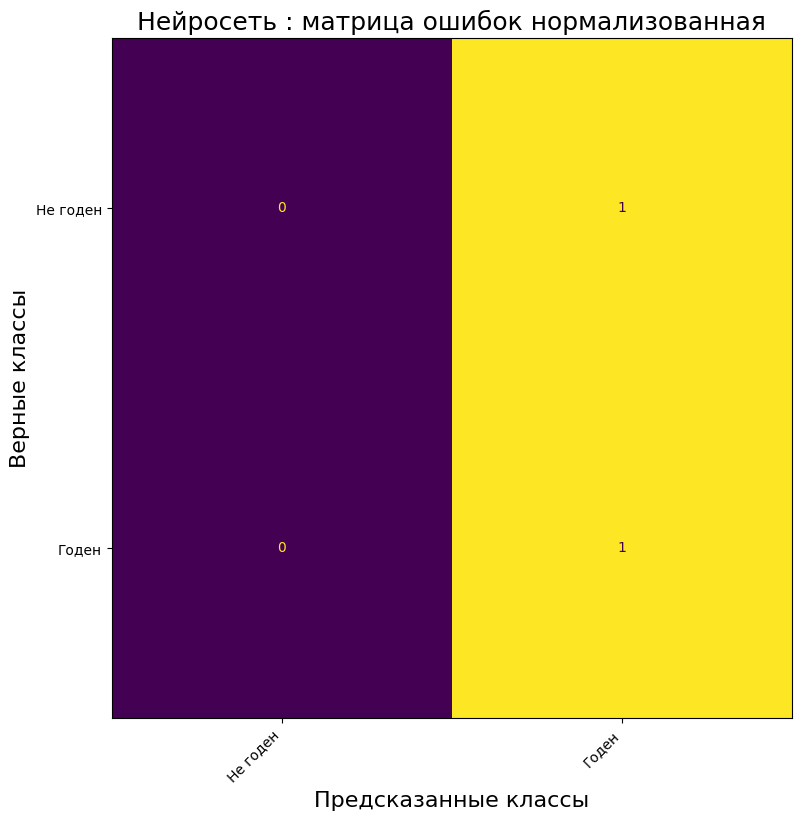

----------------------------------------------------------------------------------------------------
Нейросеть: 

Средняя точность распознавания:  50%


In [ ]:
eval_model2(model, xTrain01, yTrain, class_labels = CLASS_DICT)

# BoW на профессиях + нейронка

In [ ]:
# Выкачиваем данные по профессиям
def getXTrainTProf(values):
  xTrainTProf = []

  for val in values:
    currText = ""
    if (type(val[3]) != float):
      currText += val[3]

    xTrainTProf.append(currText)

  xTrainTProf = np.array(xTrainTProf)

  return xTrainTProf

In [ ]:
# Вытаскиваем професии для выборки
xTrainTProf = getXTrainTProf(data_new.values)
print(xTrainTProf[234]) # пример профессии

механик


In [ ]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

maxWordsCount = 10000 #определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(xTrainTProf) # "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())  #Вытаскиваем индексы слов для просмотра


In [ ]:
#преобразовываем текст в последовательность индексов согласно частотному словарю
xTrainProfIndexes = tokenizer.texts_to_sequences(xTrainTProf) #обучающие тесты в индексы

In [ ]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrainProf01 = tokenizer.sequences_to_matrix(xTrainProfIndexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
print(xTrainProf01.shape)                                       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrainProf01[0][0:100])

(1486, 10000)
[0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
n = 234
print(xTrainTProf[n])       # Профессия
print(xTrainProfIndexes[n]) # Профессия через индексы

механик
[83]


In [ ]:
xTrainProf01.shape

(1486, 10000)

In [ ]:
xTrainProf01.dtype

dtype('float64')

Epoch 1/50
60/60 [==============================] - 1s 7ms/step - loss: 0.8503 - accuracy: 0.0042 - val_loss: 0.7293 - val_accuracy: 0.0105
Epoch 2/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.0042 - val_loss: 0.5691 - val_accuracy: 0.0105
Epoch 3/50
60/60 [==============================] - 0s 4ms/step - loss: 0.5051 - accuracy: 0.0042 - val_loss: 0.4461 - val_accuracy: 0.0105
Epoch 4/50
60/60 [==============================] - 0s 4ms/step - loss: 0.3927 - accuracy: 0.0042 - val_loss: 0.3461 - val_accuracy: 0.0105
Epoch 5/50
60/60 [==============================] - 0s 4ms/step - loss: 0.3009 - accuracy: 0.0150 - val_loss: 0.2645 - val_accuracy: 0.0874
Epoch 6/50
60/60 [==============================] - 0s 5ms/step - loss: 0.2264 - accuracy: 0.8317 - val_loss: 0.1988 - val_accuracy: 0.9895
Epoch 7/50
60/60 [==============================] - 0s 6ms/step - loss: 0.1671 - accuracy: 0.9958 - val_loss: 0.1472 - val_accuracy: 0.9895
Epoch 8/50
60/60 [==

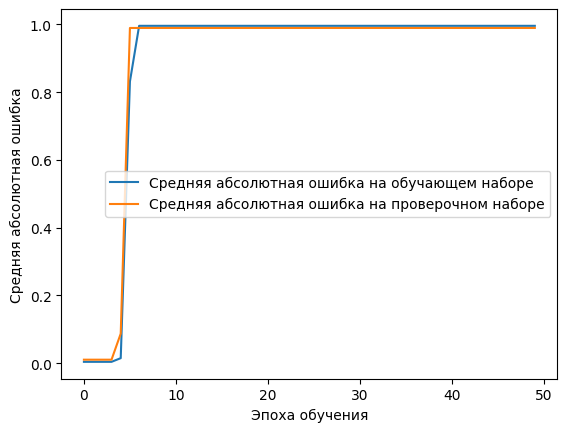

In [ ]:
# Предсказываем по профессии
modelTProf = Sequential()
modelTProf.add(Dense(20, activation='relu', input_dim=(xTrainProf01.shape[1]) ) )
modelTProf.add(Dense(500, activation='relu'))
modelTProf.add(Dense(1, activation='linear'))

modelTProf.compile(optimizer=Adagrad(lr=1e-3), loss='mse', metrics=['accuracy'])

history = modelTProf.fit(xTrainProf01[:1200],
                    yTrain[:1200],
                    batch_size=20,
                    epochs=50,
                    validation_split=0.1,
                    validation_data=(xTrainProf01[1200:], yTrain[1200:]),
                    verbose=1, shuffle=True)

plt.plot(history.history['accuracy'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

47/47 [==============================] - 0s 2ms/step


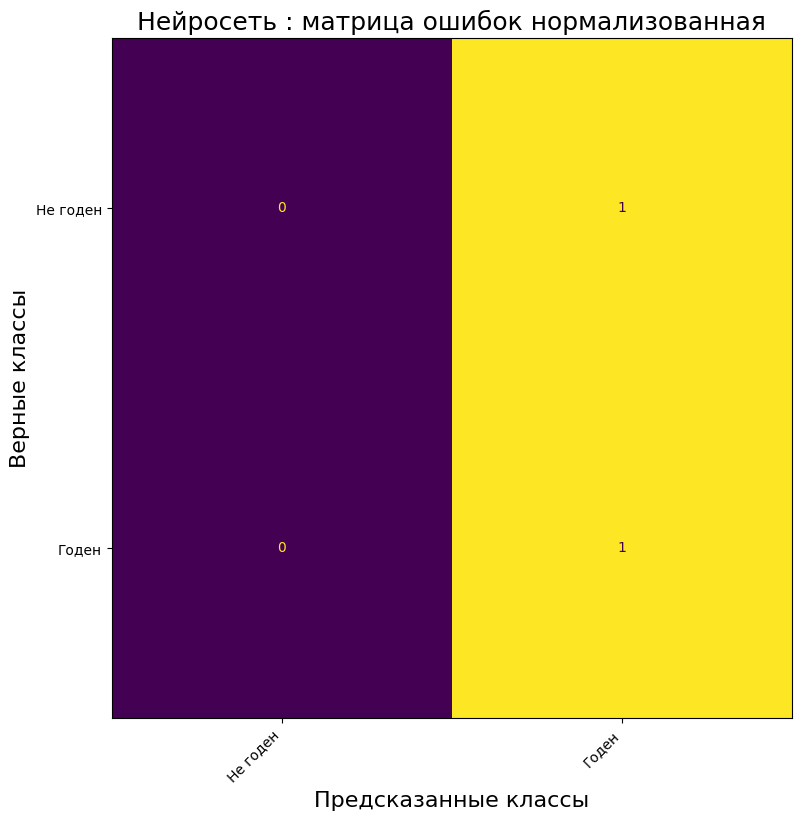

----------------------------------------------------------------------------------------------------
Нейросеть: 

Средняя точность распознавания:  50%


In [ ]:
eval_model2(modelTProf, xTrainProf01, yTrain, class_labels = CLASS_DICT)

------------------------

# BoW на вредных факторах + нейронка

In [ ]:
# Выкачиваем данные по вредным факторам
def getXTrainTVred(values):
  xTrainTVred = []

  for val in values:
    currText = ""
    if (type(val[5]) != float):
      currText += val[5]

    xTrainTVred.append(currText)

  xTrainTVred = np.array(xTrainTVred)

  return xTrainTVred

In [ ]:
# Вытаскиваем вредные факторы для выборки
xTrainTVred = getXTrainTVred(data_new.values)
print(xTrainTVred[234]) # пример вреда

4.2.5,11.1,11.4


In [ ]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

maxWordsCount = 100 #определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, split=',', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#filters= Ничего не фильтруем!!!!!!
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по запятой
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(xTrainTVred) # "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())  #Вытаскиваем индексы слов для просмотра

In [ ]:
#преобразовываем текст в последовательность индексов согласно частотному словарю
xTrainVredIndexes = tokenizer.texts_to_sequences(xTrainTVred) #обучающие тесты в индексы

In [ ]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrainVred01 = tokenizer.sequences_to_matrix(xTrainVredIndexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
print(xTrainVred01.shape)                                       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrainVred01[0][0:100])

(1486, 100)
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
n = 234
print(xTrainTVred[n])       # Vred
print(xTrainVredIndexes[n]) # Vred через индексы

4.2.5,11.1,11.4
[3, 4, 5, 7, 2, 7, 3]


In [ ]:
xTrainVred01.shape

(1486, 100)

In [ ]:
xTrainVred01.dtype

dtype('float64')

Epoch 1/50
60/60 [==============================] - 1s 6ms/step - loss: 0.7447 - accuracy: 0.0042 - val_loss: 0.5122 - val_accuracy: 0.0140
Epoch 2/50
60/60 [==============================] - 0s 4ms/step - loss: 0.3911 - accuracy: 0.1850 - val_loss: 0.2688 - val_accuracy: 0.4510
Epoch 3/50
60/60 [==============================] - 0s 4ms/step - loss: 0.2127 - accuracy: 0.6492 - val_loss: 0.1498 - val_accuracy: 0.7168
Epoch 4/50
60/60 [==============================] - 0s 4ms/step - loss: 0.1286 - accuracy: 0.7558 - val_loss: 0.1005 - val_accuracy: 0.9336
Epoch 5/50
60/60 [==============================] - 0s 4ms/step - loss: 0.0932 - accuracy: 0.9350 - val_loss: 0.0819 - val_accuracy: 0.9371
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0781 - accuracy: 0.9625 - val_loss: 0.0740 - val_accuracy: 0.9510
Epoch 7/50
60/60 [==============================] - 0s 4ms/step - loss: 0.0702 - accuracy: 0.9808 - val_loss: 0.0693 - val_accuracy: 0.9860
Epoch 8/50
60/60 [==

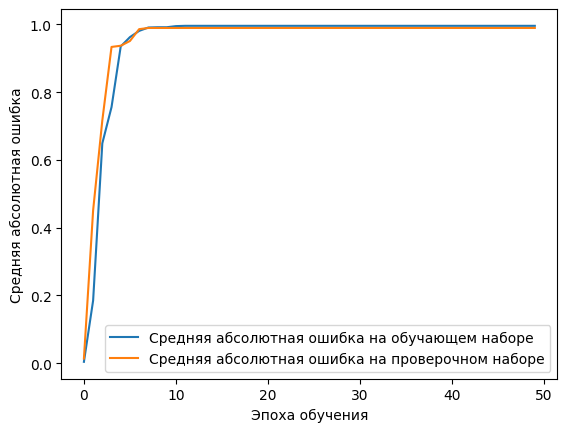

In [ ]:
# Предсказываем по профессии
modelTVred = Sequential()
modelTVred.add(Dense(20, activation='relu', input_dim=(xTrainVred01.shape[1]) ) )
modelTVred.add(Dense(500, activation='relu'))
modelTVred.add(Dense(1, activation='linear'))

modelTVred.compile(optimizer=Adagrad(lr=1e-3), loss='mse', metrics=['accuracy'])

history = modelTVred.fit(xTrainVred01[:1200],
                    yTrain[:1200],
                    batch_size=20,
                    epochs=50,
                    validation_split=0.15,
                    validation_data=(xTrainVred01[1200:], yTrain[1200:]),
                    verbose=1, shuffle=True)

plt.plot(history.history['accuracy'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

47/47 [==============================] - 0s 2ms/step


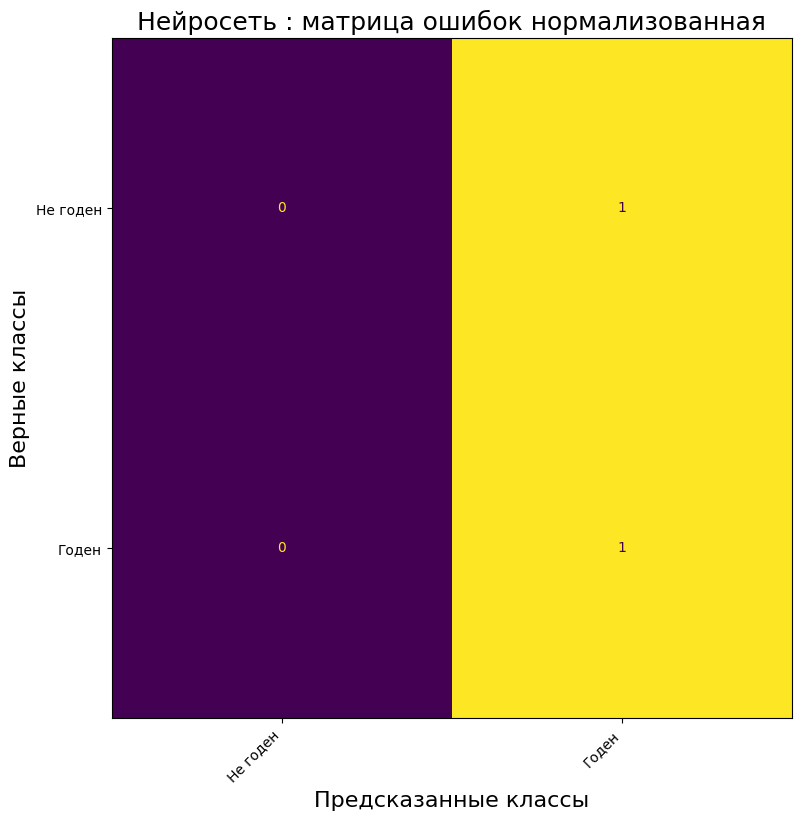

----------------------------------------------------------------------------------------------------
Нейросеть: 

Средняя точность распознавания:  50%


In [ ]:
eval_model2(modelTVred, xTrainVred01, yTrain, class_labels = CLASS_DICT)

# BoW на узких спец-ах + нейронка

In [ ]:
# Выкачиваем данные по узким спецам
def getXTrainTAll(values):
  xTrainTAll = []

  for val in values:
    currText = ""
    if (type(val[6]) != float):
      currText += val[6]

    xTrainTAll.append(currText)

  xTrainTAll = np.array(xTrainTAll)

  return xTrainTAll

In [ ]:
# Вытаскиваем осмотры для выборки
xTrainTAll = getXTrainTAll(data_new.values)
print(xTrainTAll[234]) # пример

, Астигматизм Описание: Сложный Миопический астигматизм ОД Миопия сл ст ОС ,,,,,


In [ ]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

maxWordsCount = 10000 #определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(xTrainTAll) # "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())  #Вытаскиваем индексы слов для просмотра


In [ ]:
#преобразовываем текст в последовательность индексов согласно частотному словарю
xTrainAllIndexes = tokenizer.texts_to_sequences(xTrainTAll) #обучающие тесты в индексы

In [ ]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrainAll01 = tokenizer.sequences_to_matrix(xTrainAllIndexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
print(xTrainAll01.shape)                                       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrainAll01[0][0:100])

(1486, 10000)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
n = 234
print(xTrainTAll[n])       # Профессия
print(xTrainAllIndexes[n]) # Профессия через индексы

, Астигматизм Описание: Сложный Миопический астигматизм ОД Миопия сл ст ОС ,,,,,
[4, 3, 30, 18, 4, 28, 2, 17, 15, 21]


In [ ]:
xTrainAll01.shape

(1486, 10000)

In [ ]:
xTrainAll01.dtype

dtype('float64')

Epoch 1/50
60/60 [==============================] - 2s 9ms/step - loss: 0.8289 - accuracy: 0.0042 - val_loss: 0.7032 - val_accuracy: 0.0105
Epoch 2/50
60/60 [==============================] - 0s 5ms/step - loss: 0.6198 - accuracy: 0.0042 - val_loss: 0.5405 - val_accuracy: 0.0105
Epoch 3/50
60/60 [==============================] - 0s 5ms/step - loss: 0.4796 - accuracy: 0.0042 - val_loss: 0.4169 - val_accuracy: 0.0105
Epoch 4/50
60/60 [==============================] - 0s 4ms/step - loss: 0.3691 - accuracy: 0.0042 - val_loss: 0.3178 - val_accuracy: 0.0105
Epoch 5/50
60/60 [==============================] - 0s 4ms/step - loss: 0.2799 - accuracy: 0.1283 - val_loss: 0.2379 - val_accuracy: 0.9580
Epoch 6/50
60/60 [==============================] - 0s 4ms/step - loss: 0.2086 - accuracy: 0.9900 - val_loss: 0.1749 - val_accuracy: 0.9895
Epoch 7/50
60/60 [==============================] - 0s 4ms/step - loss: 0.1526 - accuracy: 0.9958 - val_loss: 0.1264 - val_accuracy: 0.9895
Epoch 8/50
60/60 [==

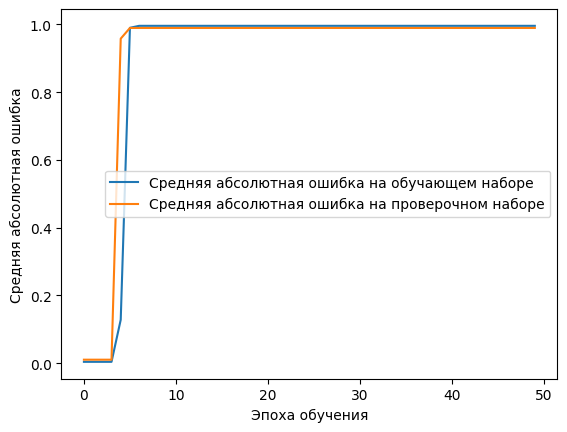

In [ ]:
# Предсказываем по узким спец-ам
modelTAll = Sequential()
modelTAll.add(Dense(20, activation='relu', input_dim=(xTrainAll01.shape[1]) ) )
modelTAll.add(Dense(500, activation='relu'))
modelTAll.add(Dense(1, activation='linear'))

modelTAll.compile(optimizer=Adagrad(lr=1e-3), loss='mse', metrics=['accuracy'])

history = modelTAll.fit(xTrainAll01[:1200],
                    yTrain[:1200],
                    batch_size=20,
                    epochs=50,
                    validation_split=0.15,
                    validation_data=(xTrainAll01[1200:], yTrain[1200:]),
                    verbose=1, shuffle=True)

plt.plot(history.history['accuracy'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

47/47 [==============================] - 0s 2ms/step


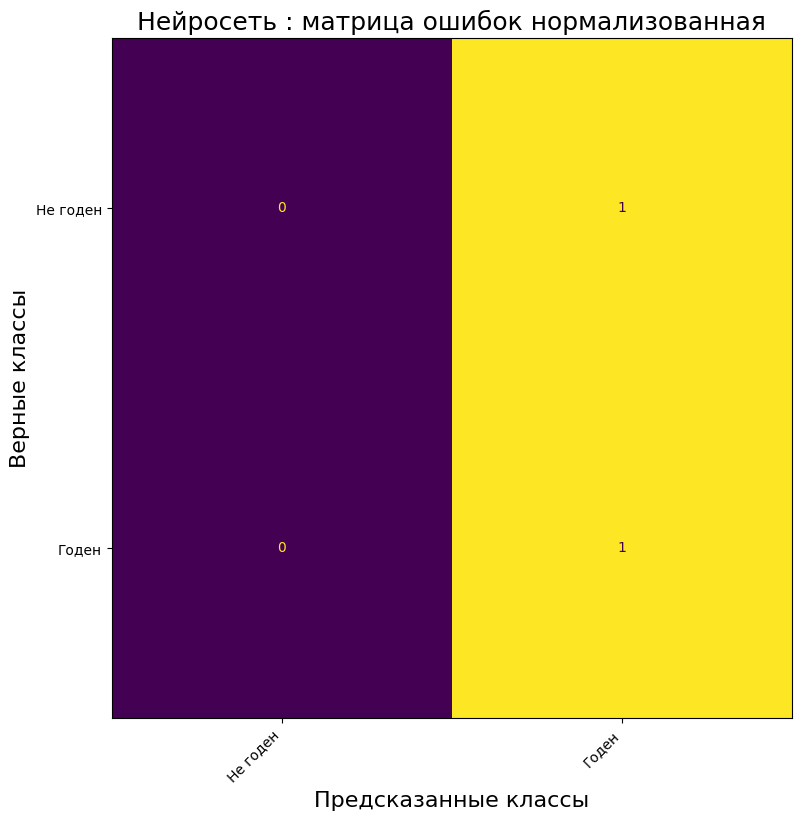

----------------------------------------------------------------------------------------------------
Нейросеть: 

Средняя точность распознавания:  50%


In [ ]:
eval_model2(modelTAll, xTrainAll01, yTrain, class_labels = CLASS_DICT)

# Составная нейронка

In [ ]:
input1 = Input((xTrain01.shape[1],))
input2 = Input((xTrainProf01.shape[1],))
input3 = Input((xTrainVred01.shape[1],))
input4 = Input((xTrainAll01.shape[1],))

x1 = BatchNormalization()(input1) # Создаем ветку х1
x1 = Dropout(0.5)(x1)
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(1000, activation="relu")(x1)
x1 = Dense(100, activation = "relu")(x1)

#x2 = BatchNormalization()(input2) # Создаем ветку х2
x2 = Dense(20, activation="relu")(input2)
x2 = Dense(500, activation="relu")(x2)
#x2 = Dense(5, activation = "elu")(x2)

#x3 = BatchNormalization()(input3) # Создаем ветку х3
x3 = Dense(20, activation="relu")(input3)
x3 = Dense(500, activation="relu")(x3)
#x3 = Dense(5, activation = "elu")(x3)

#x4 = BatchNormalization()(input4) # Создаем ветку х4
#x4 = Dense(1000, activation="tanh")(x4)
x4 = Dense(20, activation = "relu")(input4)
x4 = Dense(500, activation = "relu")(x4)

#x = concatenate([x1, x2]) # Объединяем все ветки
#x = concatenate([x1, x3])
#x = concatenate([x1, x4])
x = concatenate([x1, x2, x3, x4])

x = Dense(15, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x) # Финальный нейрон, делает регрессию

#model = Model((input1, input2), x) # В Model загружаем ... точки
#model = Model((input1, input3), x)
#model = Model((input1, input4), x)
model = Model((input1, input2, input3, input4), x)

#model.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=['accuracy'])
model.compile(optimizer=Adagrad(lr=1e-3), loss='mse', metrics=['accuracy'])
#model.compile(optimizer='rmsprop', loss='mse', metrics='accuracy')
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

#history = model.fit([xTrain01[:1200], xTrainProf01[:1200]], yTrain[:1200], epochs= 80, validation_data=([xTrain01[1200:], xTrainProf01[1200:]], yTrain[1200:]), verbose=1, shuffle=True)
#history = model.fit([xTrain01[:1200], xTrainVred01[:1200]], yTrain[:1200], epochs= 80, validation_data=([xTrain01[1200:], xTrainVred01[1200:]], yTrain[1200:]),verbose=1, shuffle=True)
#history = model.fit([xTrain01[:1200], xTrainAll01[:1200]], yTrain[:1200], epochs= 80, validation_data=([xTrain01[1200:], xTrainAll01[1200:]], yTrain[1200:]), verbose=1, shuffle=True)
#history = model.fit([xTrain01[:1200], xTrainProf01[:1200], xTrainVred01[:1200], xTrainAll01[:1200]], yTrain[:1200], epochs= 80, validation_split=0.15, validation_data=([xTrain01[1200:], xTrainProf01[1200:], xTrainVred01[1200:], xTrainAll01[1200:]], yTrain[1200:]), verbose=1, shuffle=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 10)          40          ['input_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dropout (Dropout)              (None, 10)           0           ['batch_normalization_5[0][0]']  
                                                                                                  
 dense_35 (Dense)               (None, 128)          1408        ['dropout[0][0]']            

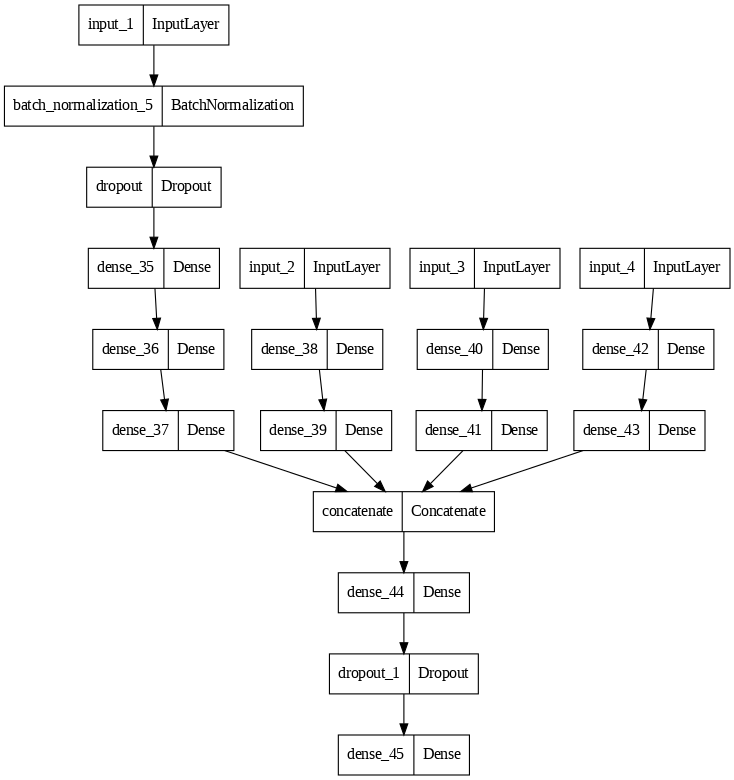

In [ ]:
model.summary()
print()
#plot_model|(model, dpi==60, show_shapes==True) # Выводим схему модели
plot_model(model, dpi=80)

In [ ]:
history = model.fit([xTrain01[:1200], xTrainProf01[:1200], xTrainVred01[:1200], xTrainAll01[:1200]], yTrain[:1200], epochs= 80, validation_split=0.15, validation_data=([xTrain01[1200:], xTrainProf01[1200:], xTrainVred01[1200:], xTrainAll01[1200:]], yTrain[1200:]), verbose=1, shuffle=True)


Epoch 1/80
38/38 [==============================] - 4s 15ms/step - loss: 0.2450 - accuracy: 0.6867 - val_loss: 0.2392 - val_accuracy: 0.9790
Epoch 2/80
38/38 [==============================] - 0s 9ms/step - loss: 0.2321 - accuracy: 0.9308 - val_loss: 0.2302 - val_accuracy: 0.9895
Epoch 3/80
38/38 [==============================] - 0s 7ms/step - loss: 0.2206 - accuracy: 0.9700 - val_loss: 0.2212 - val_accuracy: 0.9895
Epoch 4/80
38/38 [==============================] - 0s 9ms/step - loss: 0.2096 - accuracy: 0.9933 - val_loss: 0.2111 - val_accuracy: 0.9895
Epoch 5/80
38/38 [==============================] - 0s 10ms/step - loss: 0.1960 - accuracy: 0.9950 - val_loss: 0.1996 - val_accuracy: 0.9895
Epoch 6/80
38/38 [==============================] - 0s 8ms/step - loss: 0.1857 - accuracy: 0.9958 - val_loss: 0.1883 - val_accuracy: 0.9895
Epoch 7/80
38/38 [==============================] - 0s 8ms/step - loss: 0.1748 - accuracy: 0.9950 - val_loss: 0.1771 - val_accuracy: 0.9895
Epoch 8/80
38/38 [

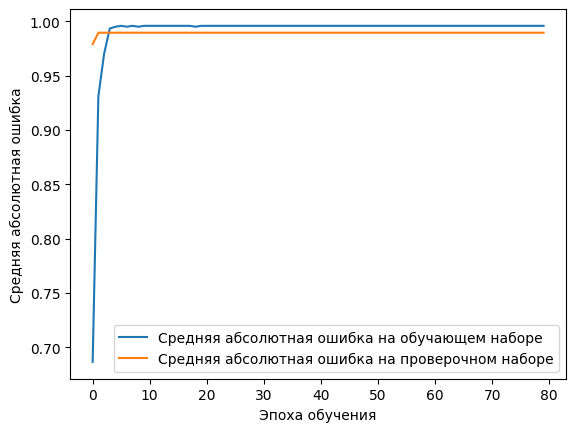

In [ ]:
plt.plot(history.history['accuracy'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

47/47 [==============================] - 0s 3ms/step


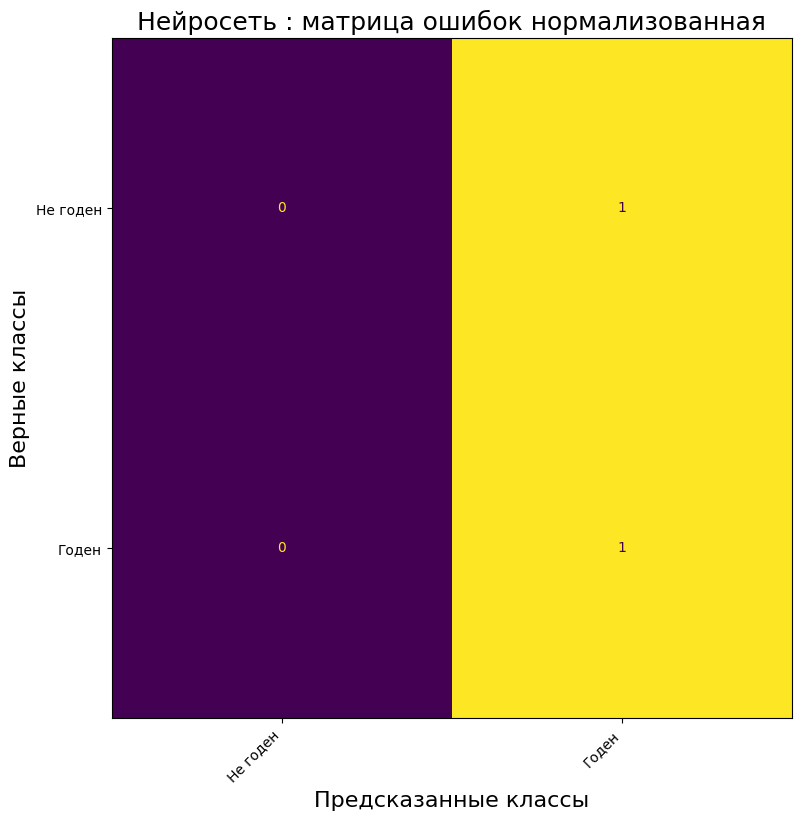

----------------------------------------------------------------------------------------------------
Нейросеть: 

Средняя точность распознавания:  50%


In [ ]:
eval_model2(model, [xTrain01, xTrainProf01, xTrainVred01, xTrainAll01], yTrain, class_labels = CLASS_DICT)

# Новый датасет

In [ ]:
!tar -xzvf /content/drive/MyDrive/УИИ/Base/all_data.tgz
!ls -lh all_data.csv

In [ ]:
df = pd.read_csv('all_data.csv', sep=';')
df.shape

<ipython-input-149-16f4156a1e79>:1: DtypeWarning: Columns (16,18,19,20,22,23,25,26,27,29,30,32,35,36,37,39,40,41,42,43,44,46,47,49,50,52,53,54,55,56,57,58,59,60,61,62,63,64,66,68,70,74,75,77,78,80,81,82,84,85,87,90,91,92,95,96,97,99,100,101,103,104,108,109,114,115,116,120,122,123,124,126,127,128,130,131,133,138,139,142,143,145,146,148,149,153,154,155,157,158,160,161,162,164,165,167,168,170,171,173,175,176,177,178,179,180,181,182,183,184,188,189,191,192,194,195,196,201,202,204,208,209,210,211,214,215,216,217,218,220,221,222,224,225,228,229,230,231,233,234,235,236,240,241,242,243,244,245,246,247,248,250,258,260,262,265,266,269,270,272,273,274,276,277,278,280,281,282,283,284,285,286,287,288) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('all_data.csv', sep=';')


(32686, 289)

In [ ]:
df.columns = [x.lower() for x in df.columns] # Приводим все заголовки к lowercase

In [ ]:
column_list = df.columns.tolist() #список столбцов
print(column_list)

['документпрохождениемедосмотра', 'клиент', 'клиентдатарождения', 'клиентпол', 'клиентполпредставление', 'датазавершениямедосмотра', 'типмедосмотра', 'типмедосмотрапредставление', 'психосвидетельствование', 'контрагент', 'цех', 'профессия', 'заключениемк', 'заключениемкпредставление', 'заключение', 'вредныефакторы', 'гинекология1_диагноз_значениепредставлениепредставление', 'гинекология1_мкб101', 'гинекология1_мкб102', 'гинекология1_мкб103', 'гинекология2_диагноз_значениепредставлениепредставление', 'гинекология2_мкб101', 'гинекология2_мкб102', 'гинекология2_мкб103', 'гинекология3_диагноз_значениепредставлениепредставление', 'гинекология3_мкб101', 'гинекология3_мкб102', 'гинекология3_мкб103', 'гинекология4_диагноз_значениепредставлениепредставление', 'гинекология4_мкб101', 'гинекология4_мкб102', 'гинекологнеисп1_диагноз_значениепредставлениепредставление', 'гинекологнеисп1_мкб101', 'дерматовенерология1_диагноз_значениепредставлениепредставление', 'дерматовенерология1_мкб101', 'дерматов

In [ ]:
len(column_list)

289

In [ ]:
df.dropna(axis=0, how='all', inplace=True) # axis=0 <-- строки (Удаляем все строки где только Nan)
df.dropna(axis=1, how='all', inplace=True) # axis=1 <-- столбцы (Удаляем все столбцы где только NaN)
df.shape

(32686, 214)

In [ ]:
df.drop_duplicates(inplace=True) # Удаляем дубликаты строк во всех столбцах

In [ ]:
df.shape

(25174, 214)

In [ ]:
df.drop_duplicates(subset=['клиент'], keep=False, inplace=True) #  Удаляем дупликаты строк по колонке ['клиент']
# keep=False для полного удаления всех дубликатов, иначе оставляет первый. Мы удаляем всех, т.к. не знаем кто из них правильный

In [ ]:
df['клиент'].nunique() # теперь только уникальные клиенты

9536

In [ ]:
# Удаляем строки где в колонках стоит NaN
df = df.dropna(subset=['заключениемк'])
df = df.dropna(subset=['клиентдатарождения'])
df = df.dropna(subset=['клиентпол'])
df = df.dropna(subset=['профессия'])
df = df.dropna(subset=['вредныефакторы'])

In [ ]:
str = ['клиент', 'клиентпол', 'клиентдатарождения', 'профессия', 'заключениемк', 'вредныефакторы']

In [ ]:
data = df[str]

In [ ]:
data.head(3)

клиент клиентпол   клиентдатарождения  \
1  b35fb2bb-9c35-11eb-80eb-0cc47aab8067   Женский  1998-07-20T00:00:00   
2  f8c98e39-9c2c-11eb-80eb-0cc47aab8067   Женский  2002-01-04T00:00:00   
4  52eb6a7d-c1ab-11ea-80dd-0cc47aab8067   Женский  1999-03-21T00:00:00   

                      профессия заключениемк вредныефакторы  
1               Продавец-кассир        Годен         04.окт  
2  Младший продавец-консультант        Годен             23  
4               Продавец-кассир        Годен             23

In [ ]:
l = data['заключениемк'].to_list()

In [ ]:
l_uniq = set(l)

In [ ]:
l_uniq

{' Газоспасатель',
 ' п. 11.3',
 'Газоспасатель',
 'Годен',
 'ГоденБезРаботНаВысотах',
 'ГоденСКоррекциейЗрения',
 'ГоденСКоррекциейСлуха',
 'Негоден',
 'НуждаетсяВДообследованииИЛечении',
 'ОграниченноГоден',
 'машинист бульдозера'}

In [ ]:
data.клиентпол.unique()

array(['Женский', 'Мужской'], dtype=object)

In [ ]:
data.клиентдатарождения.unique()

array(['1998-07-20T00:00:00', '2002-01-04T00:00:00',
       '1999-03-21T00:00:00', ..., '1988-12-24T00:00:00',
       '1989-01-05T00:00:00', '1973-09-17T00:00:00'], dtype=object)

In [ ]:
data.профессия.unique()

array(['Продавец-кассир', 'Младший продавец-консультант',
       'Продавец кассир', ..., 'Электрослесарь', ' Продавец',
       'Обвальщица'], dtype=object)

In [ ]:
data.вредныефакторы.unique()

array(['04.окт', '23', '25', ..., '1.50,4.3.2,5.1,18.2,23',
       '1.30.1,4.2.5,4.3.1,4.3.2,4.4,4.7,5.1,6.2,11.1,11.2,12,18.1,18.2',
       '18.2,1.50,4.3.2,5.1,23'], dtype=object)

In [ ]:
for x in str: # Печать уникальных значений всех столбцов.
    print('\n')
    print(f'Заголовок -> {x}\n')
    #print(return_unique_col(data, x))
    print('\n'.join(return_unique_col(data, x)))



Заголовок -> клиент

b35fb2bb-9c35-11eb-80eb-0cc47aab8067
f8c98e39-9c2c-11eb-80eb-0cc47aab8067
52eb6a7d-c1ab-11ea-80dd-0cc47aab8067
3509c445-f033-11eb-80f6-0cc47aab8067
5c945e92-e487-11eb-80f6-0cc47aab8067
76149b34-0eaa-11eb-80e3-0cc47aab8067
a280bf4d-2bff-11ec-80f9-0cc47aab8067
a280bf5c-2bff-11ec-80f9-0cc47aab8067
f3b260f2-3d6c-11e8-80c9-0cc47aab8067
e1136a51-8336-11e8-80ce-0cc47aab8067
bc386792-23e1-11eb-80e3-0cc47aab8067
1de73281-4c20-11ec-80fa-0cc47aab8067
41031ad9-0f96-11eb-80e3-0cc47aab8067
1de73279-4c20-11ec-80fa-0cc47aab8067
c8ed463e-c782-11eb-80f6-0cc47aab8067
aba4cd7c-f3b7-11e9-80d1-0cc47aab8067
aba4cd86-f3b7-11e9-80d1-0cc47aab8067
aba4cd82-f3b7-11e9-80d1-0cc47aab8067
ec19114a-3d3e-11ec-80fa-0cc47aab8067
aba4cd7e-f3b7-11e9-80d1-0cc47aab8067
ec191148-3d3e-11ec-80fa-0cc47aab8067
aba4cd80-f3b7-11e9-80d1-0cc47aab8067
47fbd8d1-4dc4-11ec-80fa-0cc47aab8067
bb74d7b0-e39f-11e7-80de-708bcd7f83cd
0bfae1be-e740-11e8-80ce-0cc47aab8067
0bfae1bf-e740-11e8-80ce-0cc47aab8067
8884e9dd-575f-1

In [ ]:
str

['клиент',
 'клиентпол',
 'клиентдатарождения',
 'профессия',
 'заключениемк',
 'вредныефакторы']

In [ ]:
data.head()

клиент клиентпол   клиентдатарождения  \
1  b35fb2bb-9c35-11eb-80eb-0cc47aab8067   Женский  1998-07-20T00:00:00   
2  f8c98e39-9c2c-11eb-80eb-0cc47aab8067   Женский  2002-01-04T00:00:00   
4  52eb6a7d-c1ab-11ea-80dd-0cc47aab8067   Женский  1999-03-21T00:00:00   
5  3509c445-f033-11eb-80f6-0cc47aab8067   Женский  2001-09-11T00:00:00   
6  5c945e92-e487-11eb-80f6-0cc47aab8067   Женский  1996-02-06T00:00:00   

                      профессия заключениемк вредныефакторы  
1               Продавец-кассир        Годен         04.окт  
2  Младший продавец-консультант        Годен             23  
4               Продавец-кассир        Годен             23  
5               Продавец кассир        Годен             23  
6                       Педагог        Годен             25

In [ ]:
# Удаляю из data в поиске по столбцу data['вредныефакторы'] строки содержащие что-то подобное
# 04.окт или 04.02.2005. Делается за счёт '|' в регулярном выражении
# и '~' отрицания. Т.е. за исключением строк с этими значениями.
data = data[~data['вредныефакторы'].str.contains('[а-яА-Я]|\\d{4}', regex=True)]
data = data.reset_index(drop=True) # Сбрасываем index.
data

клиент клиентпол   клиентдатарождения  \
0     f8c98e39-9c2c-11eb-80eb-0cc47aab8067   Женский  2002-01-04T00:00:00   
1     52eb6a7d-c1ab-11ea-80dd-0cc47aab8067   Женский  1999-03-21T00:00:00   
2     3509c445-f033-11eb-80f6-0cc47aab8067   Женский  2001-09-11T00:00:00   
3     5c945e92-e487-11eb-80f6-0cc47aab8067   Женский  1996-02-06T00:00:00   
4     76149b34-0eaa-11eb-80e3-0cc47aab8067   Мужской  1992-06-14T00:00:00   
...                                    ...       ...                  ...   
5760  9fea51f4-9ecf-11e8-80ce-0cc47aab8067   Мужской  1989-01-05T00:00:00   
5761  d29ac0b3-80fd-11ed-810a-0cc47aab8067   Мужской  1990-09-02T00:00:00   
5762  a5afaa01-4de7-11ed-8107-0cc47aab8067   Мужской  1995-11-07T00:00:00   
5763  0e3d319f-cf32-11e7-80de-708bcd7f83cd   Мужской  1991-01-13T00:00:00   
5764  7db8d4db-36eb-11ec-80fa-0cc47aab8067   Мужской  1973-09-17T00:00:00   

                                    профессия заключениемк  \
0                Младший продавец-консультант        Годен   
1                             Продавец-кассир        Годен   
2                             Продавец кассир        Годен   
3                                     Педагог        Годен   
4     Монтажник технологических трубопроводов        Годен   
...                                       ...          ...   
5760                      Водитель автомобиля        Годен   
5761                      Водитель автомобиля        Годен   
5762                      Водитель автомобиля        Годен   
5763                      Водитель автомобиля        Годен   
5764                      Водитель автомобиля        Годен   

              вредныефакторы  
0                         23  
1                         23  
2                         23  
3                         25  
4        4.4,5.1,15,6.1,11.4  
...                      ...  
5760  18.2,1.50,4.3.2,5.1,23  
5761  23,18.2,4.3.2,5.1,1.50  
5762  1.50,4.3.2,5.1,18.2,23  
5763  1.50,4.3.2,5.1,18.2,23  
5764  23,18.2,4.3.2,5.1,1.50  

[5765 rows x 6 columns]

In [ ]:
data.info

<bound method DataFrame.info of                                     клиент клиентпол   клиентдатарождения  \
0     f8c98e39-9c2c-11eb-80eb-0cc47aab8067   Женский  2002-01-04T00:00:00   
1     52eb6a7d-c1ab-11ea-80dd-0cc47aab8067   Женский  1999-03-21T00:00:00   
2     3509c445-f033-11eb-80f6-0cc47aab8067   Женский  2001-09-11T00:00:00   
3     5c945e92-e487-11eb-80f6-0cc47aab8067   Женский  1996-02-06T00:00:00   
4     76149b34-0eaa-11eb-80e3-0cc47aab8067   Мужской  1992-06-14T00:00:00   
...                                    ...       ...                  ...   
5760  9fea51f4-9ecf-11e8-80ce-0cc47aab8067   Мужской  1989-01-05T00:00:00   
5761  d29ac0b3-80fd-11ed-810a-0cc47aab8067   Мужской  1990-09-02T00:00:00   
5762  a5afaa01-4de7-11ed-8107-0cc47aab8067   Мужской  1995-11-07T00:00:00   
5763  0e3d319f-cf32-11e7-80de-708bcd7f83cd   Мужской  1991-01-13T00:00:00   
5764  7db8d4db-36eb-11ec-80fa-0cc47aab8067   Мужской  1973-09-17T00:00:00   

                                    професс

In [ ]:
data['клиентдатарождения'] = pd.to_datetime(data['клиентдатарождения'], errors='coerce').dt.date

In [ ]:
data['возраст'] = (date.today() - data['клиентдатарождения']).astype('<m8[Y]')

In [ ]:
data.head(3)

клиент клиентпол клиентдатарождения  \
0  f8c98e39-9c2c-11eb-80eb-0cc47aab8067   Женский         2002-01-04   
1  52eb6a7d-c1ab-11ea-80dd-0cc47aab8067   Женский         1999-03-21   
2  3509c445-f033-11eb-80f6-0cc47aab8067   Женский         2001-09-11   

                      профессия заключениемк вредныефакторы  возраст  
0  Младший продавец-консультант        Годен             23     21.0  
1               Продавец-кассир        Годен             23     24.0  
2               Продавец кассир        Годен             23     21.0

In [ ]:
data['возраст_класс'] = (data['возраст'] - 13)//7

In [ ]:
# Вставляю в мой список заголовков новый заголовок "возраст_класс" по 2-му индексу. 0,1,2 <-- сюда
if str.count('возраст_класс') == 0: # Необходимо проверять, что уже добавил т.к. могу ещё раз запустить ячейку. Чтобы не добавлялось каждый раз.
    str.insert(3, 'возраст_класс')
else:
    print('Заголовок "возраст_класс" уже добавлен в список\n')

In [ ]:
# Удаляю ненужный более заголовок "клиентдатарождения" Можно было заодно сделать выше, но это неправильно.
# Лучше иметь атомарные операции, чем в одну пихать несколько.
if str.count('клиентдатарождения') > 0:
    str.remove('клиентдатарождения')
else:
    print('Заголовок "клиентдатарождения" уже удалён\n')

In [ ]:
str

['клиент',
 'клиентпол',
 'возраст_класс',
 'профессия',
 'заключениемк',
 'вредныефакторы']

In [ ]:
data_new_1 = data[str]

In [ ]:
data_new_1.head(3)

клиент клиентпол  возраст_класс  \
0  f8c98e39-9c2c-11eb-80eb-0cc47aab8067   Женский            1.0   
1  52eb6a7d-c1ab-11ea-80dd-0cc47aab8067   Женский            1.0   
2  3509c445-f033-11eb-80f6-0cc47aab8067   Женский            1.0   

                      профессия заключениемк вредныефакторы  
0  Младший продавец-консультант        Годен             23  
1               Продавец-кассир        Годен             23  
2               Продавец кассир        Годен             23

In [ ]:
data_new_1.dtypes

клиент             object
клиентпол          object
возраст_класс     float64
профессия          object
заключениемк       object
вредныефакторы     object
dtype: object

In [ ]:
data_new_1 = data_new_1.dropna(subset=['возраст_класс'])

In [ ]:
data_new_1['возраст_класс'] = data_new_1['возраст_класс'].astype('int8')

<ipython-input-186-9e9eb84dcfec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new_1['возраст_класс'] = data_new_1['возраст_класс'].astype('int8')


In [ ]:
data_new_1.dtypes

клиент            object
клиентпол         object
возраст_класс       int8
профессия         object
заключениемк      object
вредныефакторы    object
dtype: object

# Сливаем датасеты